# Решение задач о предсказании уровня удовлетворённости сотрудника в компании и предсказании увольнения сотрудника из неё.


Мы HR-аналитики компании «Работа с заботой» и мы помогаем бизнесу оптимизировать управлять персоналом: бизнес предоставляет данные, а аналитики компании предлагают способы избежать финансовых потерь и оттока сотрудников. Машинное обучение значительно повышает эффективность и точность этих анализов, позволяя быстрее и точнее отвечать на вопросы бизнеса.

Нам компания предоставила данные о характеристиках своих сотрудников, включая уровень удовлетворённости работой. Эта информация была получена из форм обратной связи, где сотрудники заполняют тест-опросник, а их удовлетворённость оценивается по шкале от 0 до 1, где 0 — полностью неудовлетворён, 1 — полностью удовлетворён.

Перед нами стоит несколько задач:

 - Построить модель, которая предсказывает уровень удовлетворённости сотрудника на основе данных компании.
Удовлетворённость работой напрямую влияет на отток сотрудников. Прогнозирование уровня удовлетворённости поможет предотвратить внезапные увольнения, которые могут быть рискованными для компании, особенно если уходит ключевой сотрудник.

 - Построить модель, которая предсказывает вероятность увольнения сотрудника на основе данных компании.
Предсказание оттока сотрудников — одна из важнейших задач HR-аналитиков. Внезапные увольнения могут быть серьёзным риском для компании, и раннее предупреждение об этом может помочь принять превентивные меры.

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Шаг 1. Загрузка данных

In [123]:
!pip install numba==0.59.1 -q
!pip install numpy==1.26.4 -q
!pip install scipy==1.13.1 -q
!pip install -U scikit-learn -q
!pip install seaborn==0.13.2 -q
!pip install matplotlib==3.9.0 -q
!pip install shap -q
!pip install phik==0.12.4 -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import shap
import phik
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

Для начала загрузим наши исходные датасеты. В них ходят 'train_job_satisfaction_rate' это тренировочная выборка, 'test_features' - входные признаки тестовой выборки и 'test_target_job_satisfaction_rate' это целевой признак тестовой выборки.

In [124]:
# Прочитайте CSV-файл в DataFrame
train = pd.read_csv('train_job_satisfaction_rate.csv')
X_test = pd.read_csv('test_features.csv')
y_test_1 = pd.read_csv('test_target_job_satisfaction_rate.csv')

In [125]:
display(train.head(5))
train.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [126]:
display(X_test.head(5))
X_test.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [127]:
display(y_test_1.head(5))
y_test_1.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Выведем количество пропусков в каждом датасете

In [128]:
print(train.isna().sum())
print(X_test.isna().sum())
print(y_test_1.isna().sum())

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id                       0
job_satisfaction_rate    0
dtype: int64


В тренировочной выборке содержится 4000 строк, в тестовой выборке с входными данными 2000 строк, в тестовой выборке с целевым признаком также 2000 строк. Как мы сразу можем заметить в исходных датафреймах присутствуют пропуски в столбцах 'dept' и 'level'. Также, во всех столбцах используется корректный тип данных.

## Шаг 2. Предобработка данных

Далее займемся предобработкой исходных данных. В данных присутствуют пропуски, но их обработкой займемся чуть позже, на этапе работы с пайплайном. После произведем проверку наших датасетов на наличие полных дубликатов.

In [129]:
print(train.duplicated().sum())
print(X_test.duplicated().sum())
print(y_test_1.duplicated().sum())

0
0
0


Полных дубликатов не обнаружено, проверим на наличие неявных дубликатов

In [130]:
print(train['id'].value_counts())
print(X_test['id'].value_counts())
print(y_test_1['id'].value_counts())

id
155278    1
547451    1
329455    1
126257    1
912452    1
         ..
560669    1
504437    1
687933    1
169965    1
338347    1
Name: count, Length: 4000, dtype: int64
id
485046    1
754136    1
862904    1
734514    1
160031    1
         ..
959945    1
549540    1
969698    1
790117    1
771859    1
Name: count, Length: 2000, dtype: int64
id
130604    1
230381    1
545992    1
645413    1
203250    1
         ..
754136    1
726880    1
767570    1
642991    1
648995    1
Name: count, Length: 2000, dtype: int64


Дубликатов в данных не обнаружено. Проверим категориальные признаки на наличие ошибок

In [131]:
# для датасета train
print(train['dept'].unique())
print(train['level'].unique())
print(train['workload'].unique())
print(train['last_year_promo'].unique())
print(train['last_year_violations'].unique())

# для датасета X_test
print(X_test['dept'].unique())
print(X_test['level'].unique())
print(X_test['workload'].unique())
print(X_test['last_year_promo'].unique())
print(X_test['last_year_violations'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Как мы можем заметить, в тестовой выборке есть пустые значения. Заменим их в этих колонках на NaN.

In [132]:
# Заменим пустые строки на NaN
X_test.replace(' ', np.nan, inplace=True)

# Проверим наше преобразование
print(X_test['dept'].unique())
print(X_test['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


Также, перепроверим наименование столбцов.

In [133]:
print(train.columns.tolist())
print(X_test.columns.tolist())
print(y_test_1.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
['id', 'job_satisfaction_rate']


Во 2 шаге нашей работы мы начали предобработку исходных данных. Обнаружив пропуски, решили отложить их обработку до этапа работы с пайплайном. Затем проверили наши датасеты на наличие полных дубликатов и не нашли их. Проверка на наличие неявных дубликатов также не выявила дубликатов в данных. Далее мы проверили категориальные признаки на наличие ошибок и перепроверили наименование столбцов. Нашли пустые значения в двух колонках тестовой выборки и заменили их на NaN. Все данные оказались корректными.

## Шаг 3. Исследовательский анализ данных

Далее, проведем исследовательский анализ данных для каждой таблицы и исследуем все признаки.

К количественным признакам:

 - в датафрейме train относятся такие признаки, как 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'
 - в датафрейме X_test все те же признаки, кроме 'job_satisfaction_rate'
 - в датафрейме y_test_1 это 'job_satisfaction_rate'

К категориальным признакам относятся:

 - в датафрейме train относятся такие признаки, как 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'
 - в датафрейме X_test такие же категориальные признаки
 - в датафрейме y_test_1 их нет

Построим графики по количественным признакам — гистограмму частотности распределения и ящик с усами для каждого признака

In [134]:
display(train[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']].describe().T)
display(X_test[['employment_years', 'supervisor_evaluation', 'salary']].describe().T)
display(y_test_1[['job_satisfaction_rate']].describe().T)

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


Как мы можем заметить, данные в тренировочной и тестовой выборках распределены очень похоже. Средние, медианные, максимальные и минимальные значения примерно совпадают, что облегчает моделям предсказание удовлетворенности на тестовой выборке.

1) Длительность работы в компании - employment_years

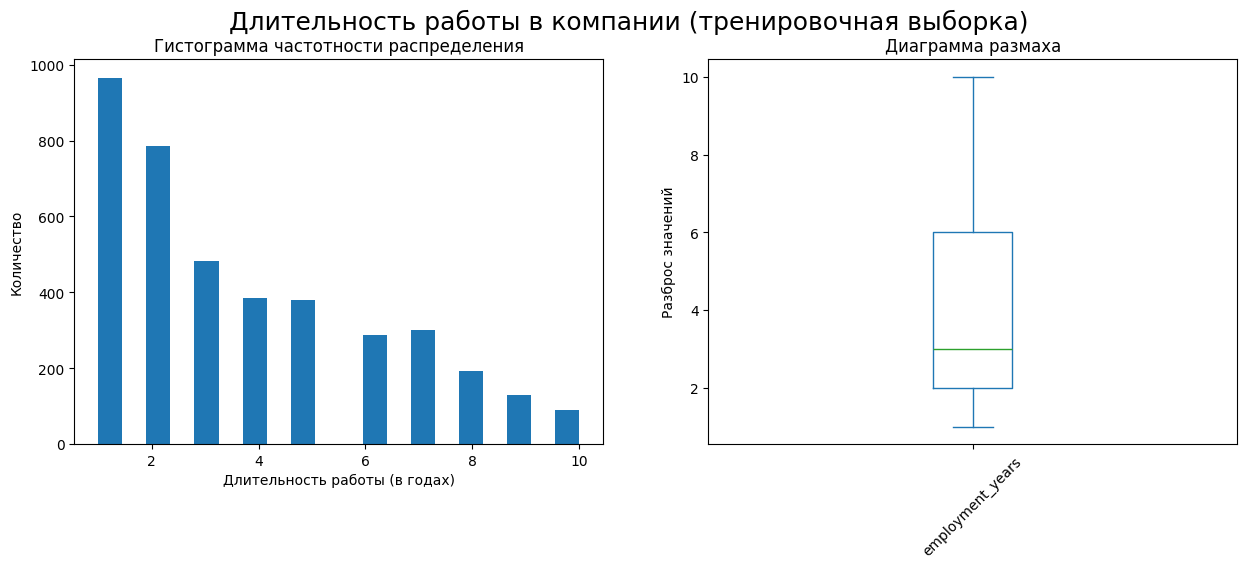

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Длительность работы в компании (тренировочная выборка)  ', fontsize=18)
train['employment_years'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Длительность работы (в годах)')
axes[0].set_ylabel('Количество')

train['employment_years'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

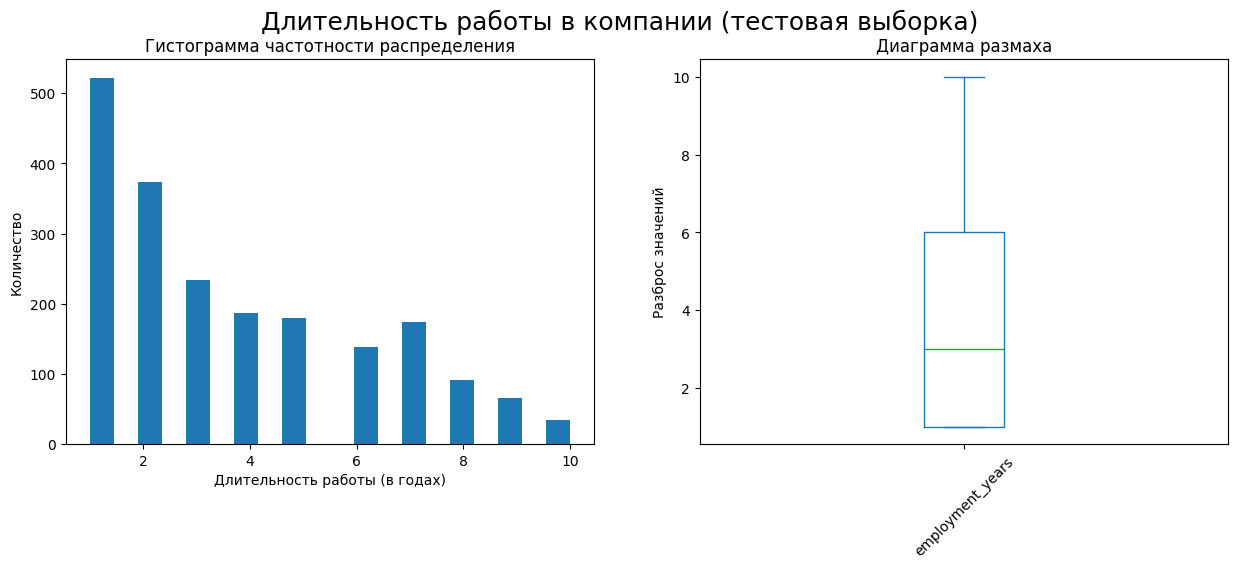

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Длительность работы в компании (тестовая выборка)  ', fontsize=18)
X_test['employment_years'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Длительность работы (в годах)')
axes[0].set_ylabel('Количество')

X_test['employment_years'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

По диаграммам видно, что люди работают в компании от 1 до 10 лет, причем в обоих случаях большая часть сотрудников работает в компании не более 3 лет. Также можно заметить, что с увеличением стажа в компании количество сотрудников снижается. Выбрасов никаких не наблюдается

2) Оценка качества работы сотрудника - supervisor_evaluation

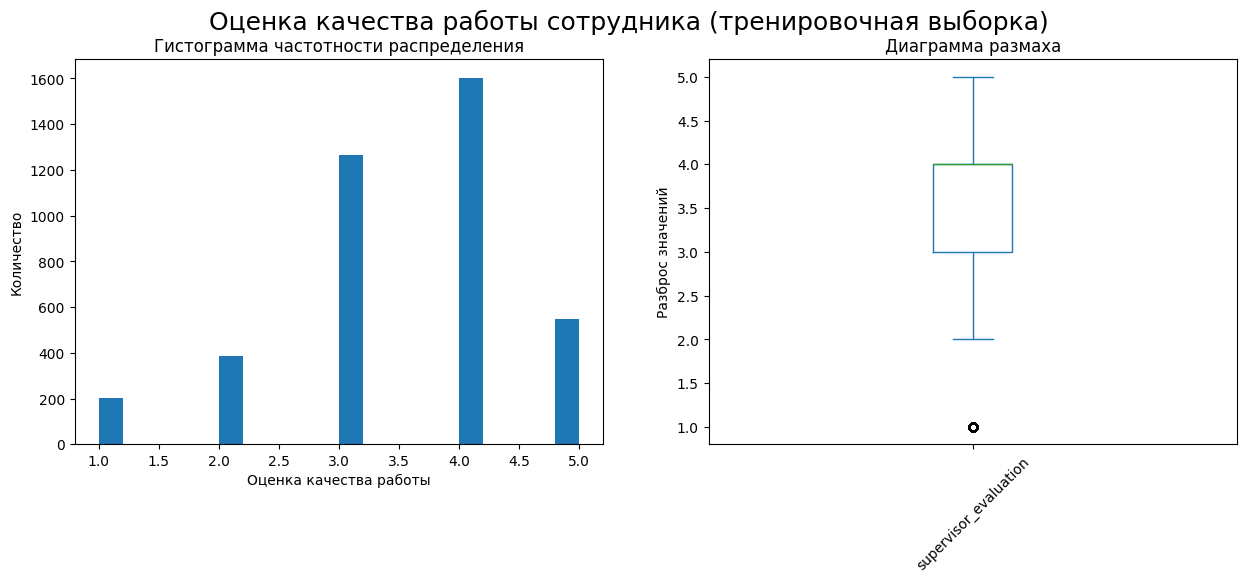

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Оценка качества работы сотрудника (тренировочная выборка)  ', fontsize=18)
train['supervisor_evaluation'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Оценка качества работы')
axes[0].set_ylabel('Количество')

train['supervisor_evaluation'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

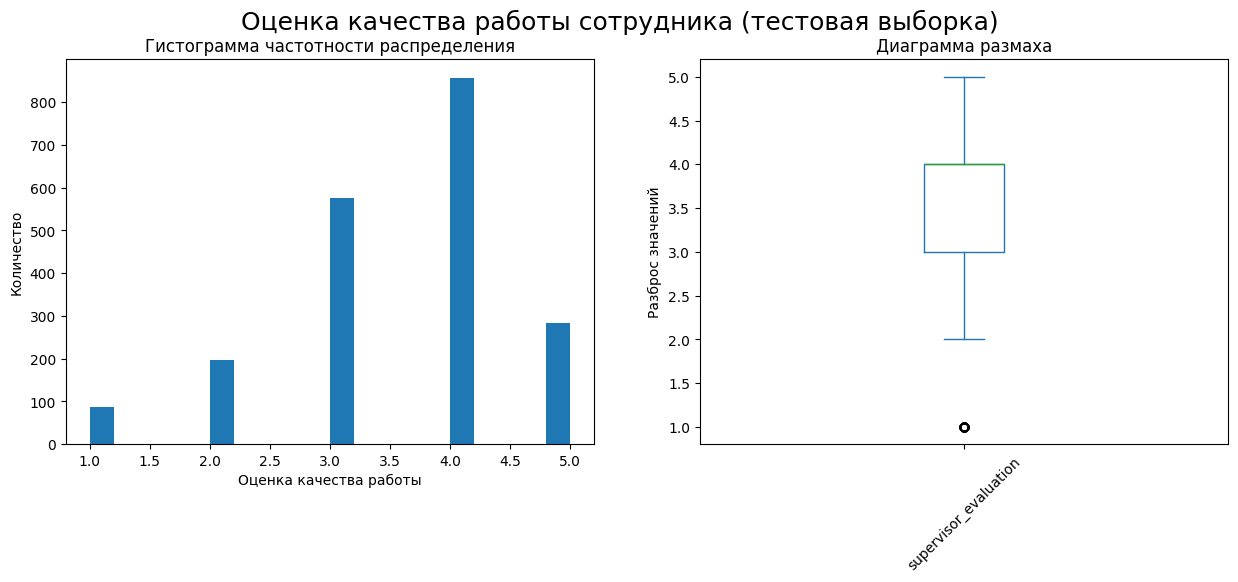

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Оценка качества работы сотрудника (тестовая выборка)  ', fontsize=18)
X_test['supervisor_evaluation'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Оценка качества работы')
axes[0].set_ylabel('Количество')

X_test['supervisor_evaluation'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

В обоих случаях, данные выглядят вполне адекватными, поэтому не будем избавляться от выбрасов. Оценка качества работы сотрудника, которую дал руководитель, варьируется от 1 до 5 и больше всего оценки 4.

3) Ежемесячная зарплата сотрудника - salary

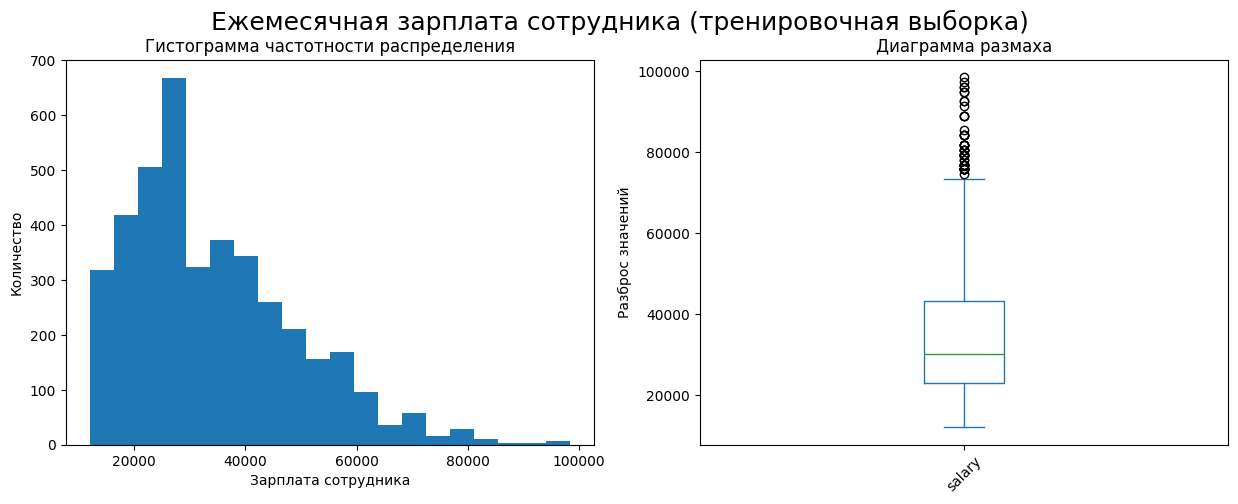

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Ежемесячная зарплата сотрудника (тренировочная выборка)  ', fontsize=18)
train['salary'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Зарплата сотрудника')
axes[0].set_ylabel('Количество')

train['salary'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

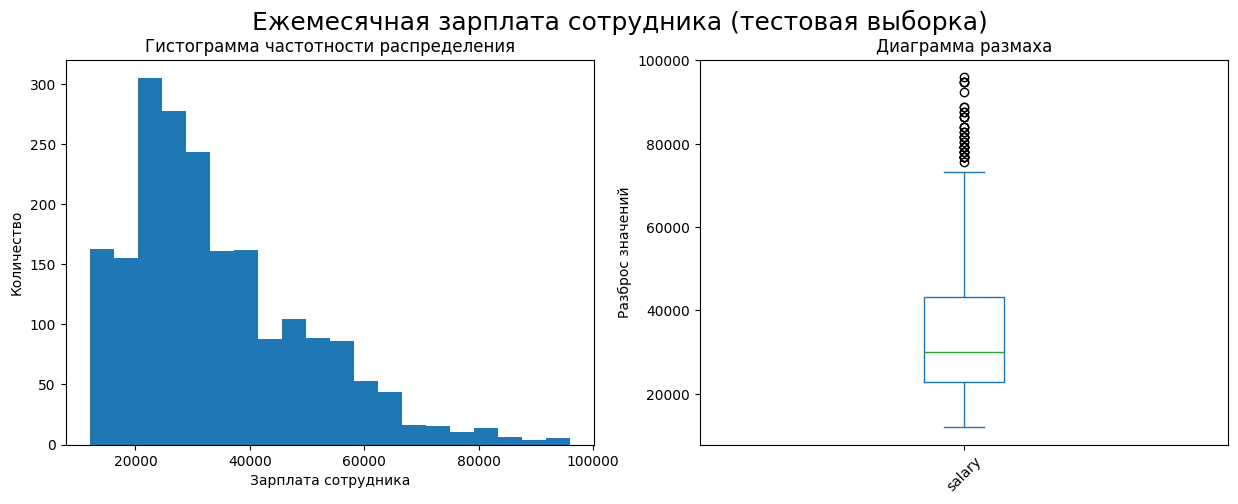

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Ежемесячная зарплата сотрудника (тестовая выборка)  ', fontsize=18)
X_test['salary'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Зарплата сотрудника')
axes[0].set_ylabel('Количество')

X_test['salary'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Мы не будем избавляться от выбросов, так как данные выглядят нормально. В ежемесячной зарплате сотрудников график имеет вид номрального распределения со сдвигом влево. Зарплаты сотрудников в обоих случаях варьируются от 12,000 до 100,000, и большинство получает около 34,000.

4) Уровень удовлетворённости сотрудника работой в компании, целевой признак - job_satisfaction_rate

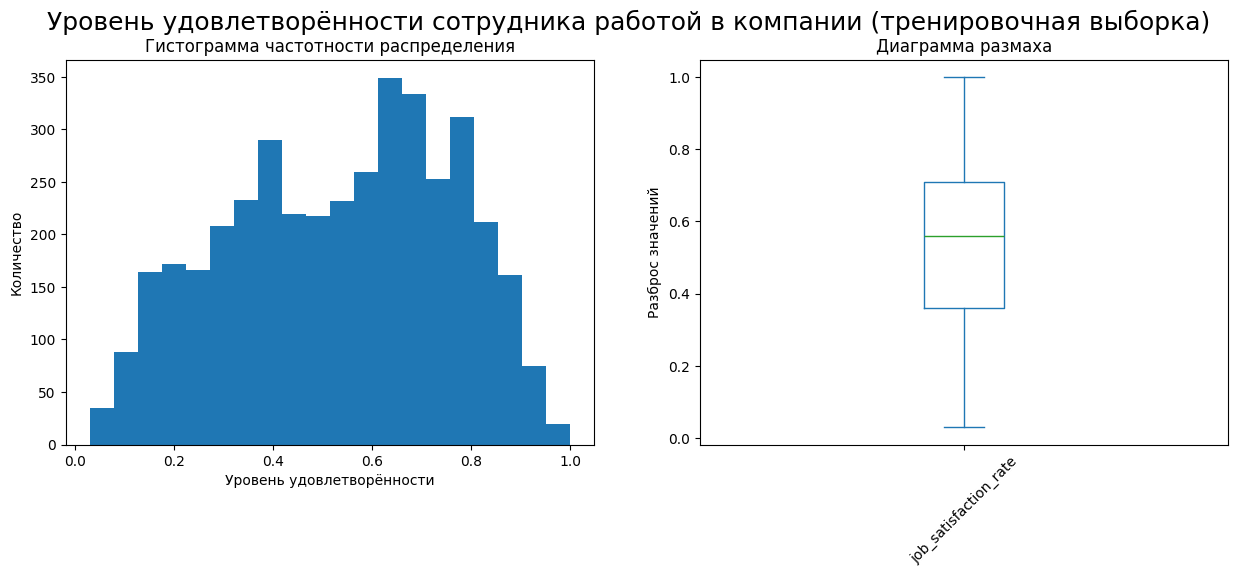

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Уровень удовлетворённости сотрудника работой в компании (тренировочная выборка)', fontsize=18)
train['job_satisfaction_rate'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Уровень удовлетворённости')
axes[0].set_ylabel('Количество')

train['job_satisfaction_rate'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

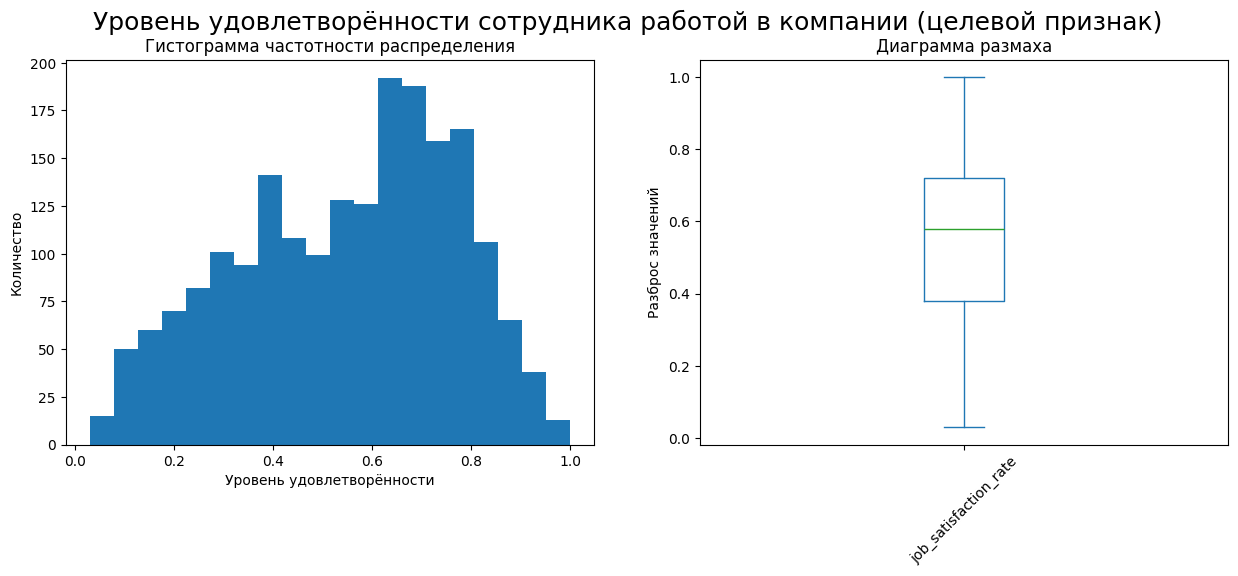

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Уровень удовлетворённости сотрудника работой в компании (целевой признак)', fontsize=18)
y_test_1['job_satisfaction_rate'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Уровень удовлетворённости')
axes[0].set_ylabel('Количество')

y_test_1['job_satisfaction_rate'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Уровень удовлетворённости сотрудника работой в компании находится в диапазоне от 0.03 до 1.0. Графики имеют вид номрального распределения со сдвигом вправо. Выбрасов в данных не обнаружено.

Получается, что в тренировочной и тестовой выборках данные количественных признаков примерно схожи. Отрицательных и аномальных значений нет, данные выглядят достоверно.

Далее рассмотрим категориальные признаки всех датасетов. Построим круговые диаграммы по каждому признаку для обеих выборок.

1) Отдел, в котором работает сотрудник - dept

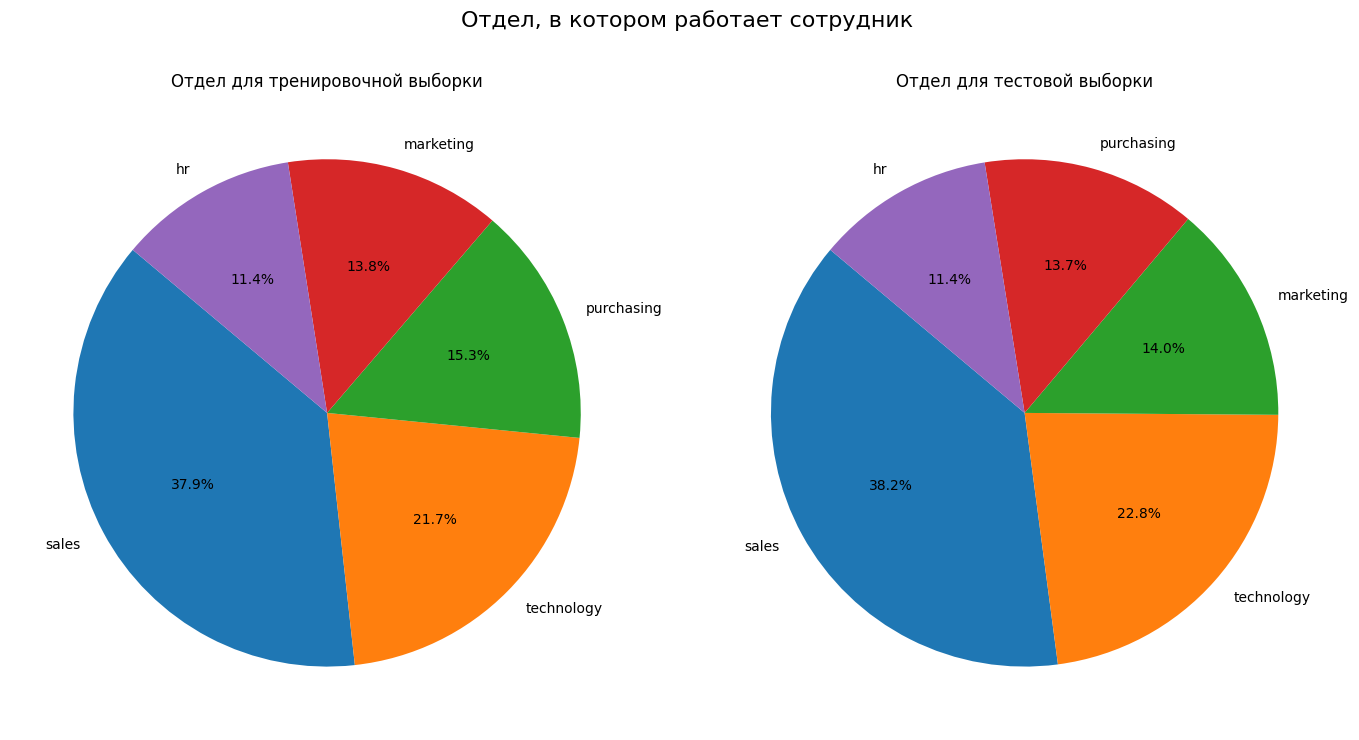

In [143]:
train_dept_counts = train['dept'].value_counts()
X_test_dept_counts = X_test['dept'].value_counts()
# Подготовка данных для графика
labels_train = train_dept_counts.index
sizes_train = train_dept_counts.values

labels_X_test = X_test_dept_counts.index
sizes_X_test = X_test_dept_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Отдел для тренировочной выборки')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_X_test, labels=labels_X_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Отдел для тестовой выборки')

plt.suptitle("Отдел, в котором работает сотрудник", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Значения 2х выборок примерно похожи. Больше всего сотрудников в компании на должности связанной с продажами. Меньше всего hr-работников.

2) Уровень занимаемой должности - level

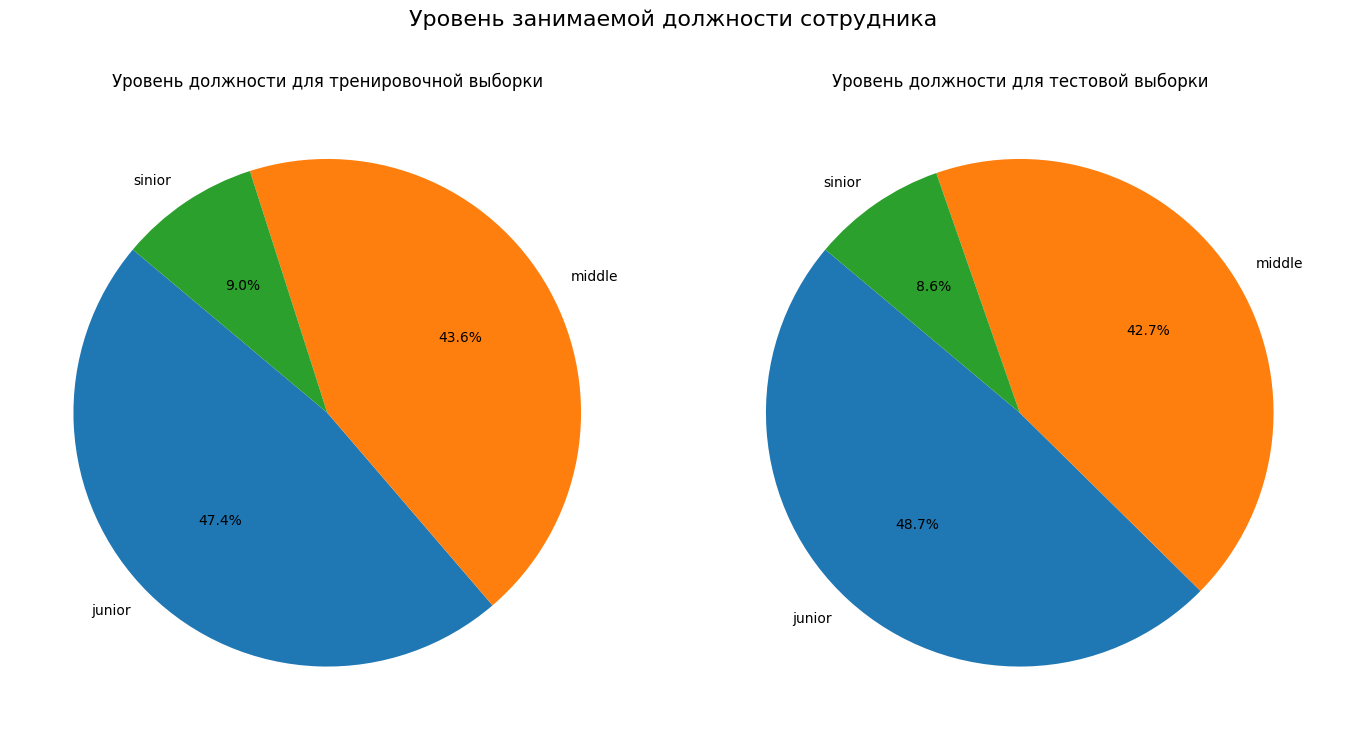

In [144]:
train_level_counts = train['level'].value_counts()
X_test_level_counts = X_test['level'].value_counts()
# Подготовка данных для графика
labels_train = train_level_counts.index
sizes_train = train_level_counts.values

labels_X_test = X_test_level_counts.index
sizes_X_test = X_test_level_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Уровень должности для тренировочной выборки')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_X_test, labels=labels_X_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Уровень должности для тестовой выборки')

plt.suptitle("Уровень занимаемой должности сотрудника", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

В компании очень много людей занимают должность junior и middle и менее 10 процентов сотрудников занимают должность sinior

3) Уровень загруженности сотрудника - workload

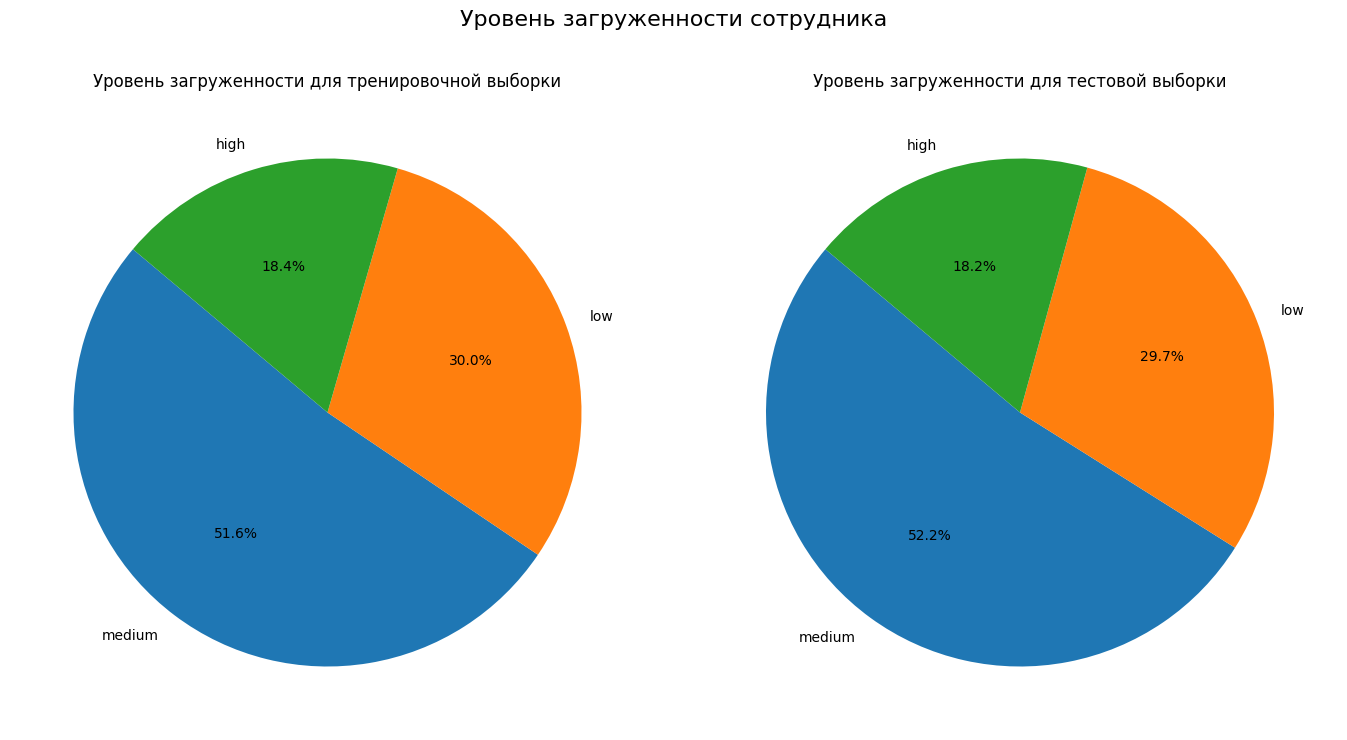

In [145]:
train_workload_counts = train['workload'].value_counts()
X_test_workload_counts = X_test['workload'].value_counts()
# Подготовка данных для графика
labels_train = train_workload_counts.index
sizes_train = train_workload_counts.values

labels_X_test = X_test_workload_counts.index
sizes_X_test = X_test_workload_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Уровень загруженности для тренировочной выборки')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_X_test, labels=labels_X_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Уровень загруженности для тестовой выборки')

plt.suptitle("Уровень загруженности сотрудника", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

По загруженности больше всего сотрудников со средним уровнем загруженности. Также около 30% сотрудников имеют низкую загруженность.

4) Значение показывает, было ли повышение за последний год - last_year_promo

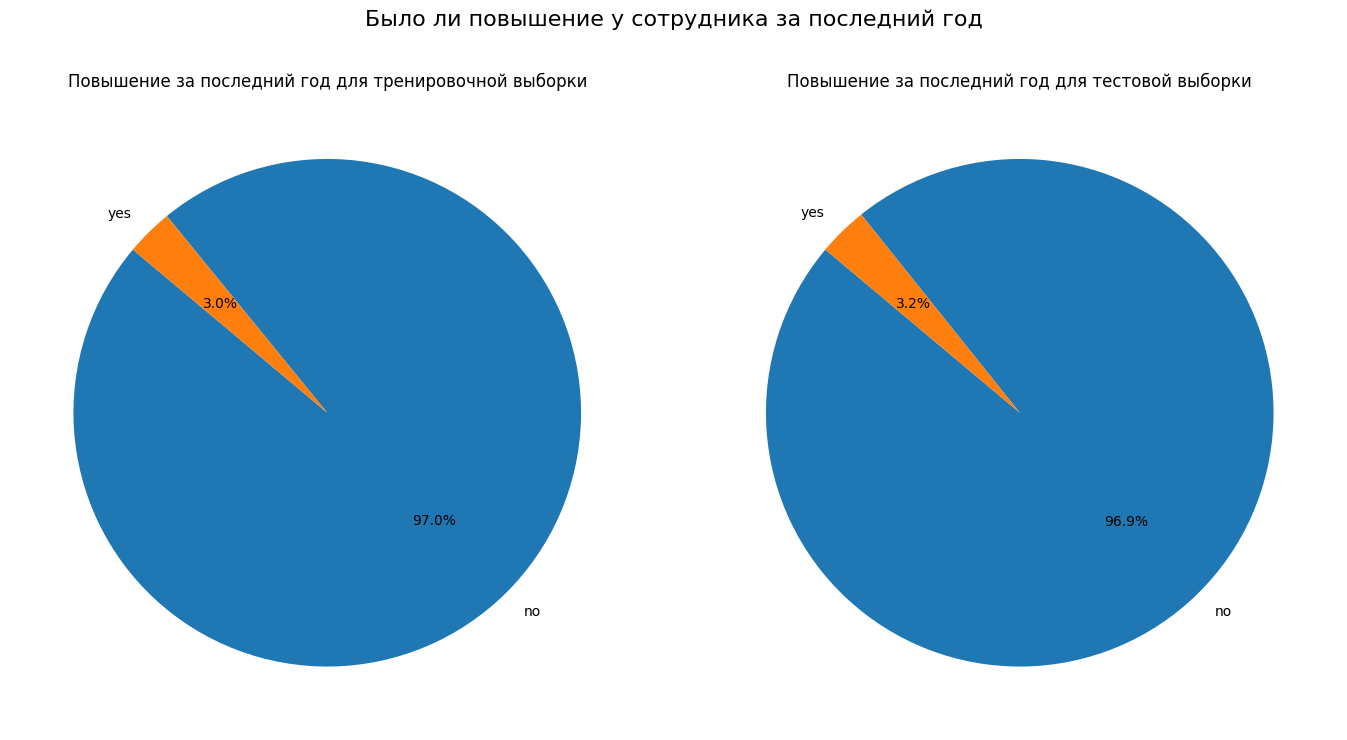

In [146]:
train_last_year_promo_counts = train['last_year_promo'].value_counts()
X_test_last_year_promo_counts = X_test['last_year_promo'].value_counts()
# Подготовка данных для графика
labels_train = train_last_year_promo_counts.index
sizes_train = train_last_year_promo_counts.values

labels_X_test = X_test_last_year_promo_counts.index
sizes_X_test = X_test_last_year_promo_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Повышение за последний год для тренировочной выборки')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_X_test, labels=labels_X_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Повышение за последний год для тестовой выборки')

plt.suptitle("Было ли повышение у сотрудника за последний год", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Как видно из данных графиков, повышение было только у 3% сотрудников из всего штата в обеих выборках.

5) Значение показывает, нарушал ли сотрудник трудовой договор за последний год - last_year_violations

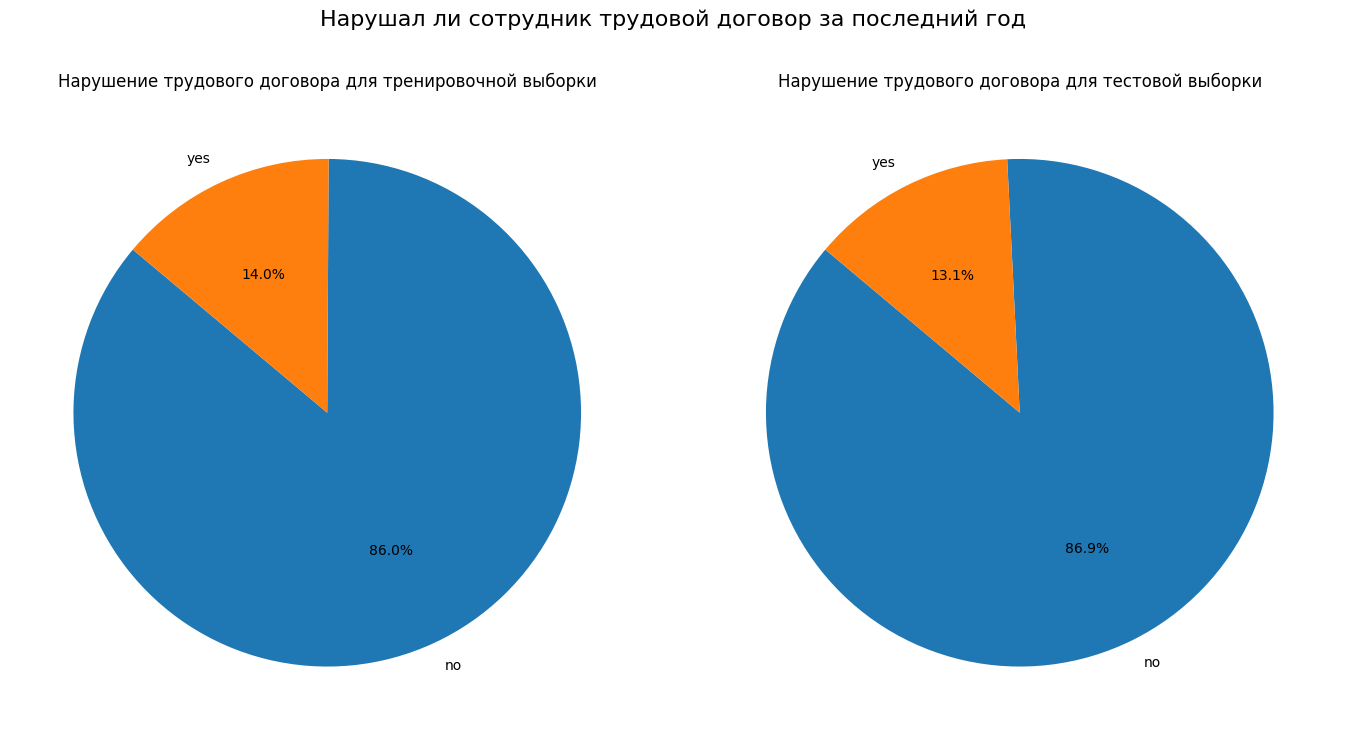

In [147]:
train_last_year_violations_counts = train['last_year_violations'].value_counts()
X_test_last_year_violations_counts = X_test['last_year_violations'].value_counts()
# Подготовка данных для графика
labels_train = train_last_year_violations_counts.index
sizes_train = train_last_year_violations_counts.values

labels_X_test = X_test_last_year_violations_counts.index
sizes_X_test = X_test_last_year_violations_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Нарушение трудового договора для тренировочной выборки')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_X_test, labels=labels_X_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Нарушение трудового договора для тестовой выборки')

plt.suptitle("Нарушал ли сотрудник трудовой договор за последний год", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Распределение данных в тестовой и тренировочной выборках практически идентичное. Нарушения трудового договора выявлены у 13-14% сотрудников.

Далее, после рассмотрения признаков, можно для оценки взаимосвязей провести корреляционный анализ признаков.

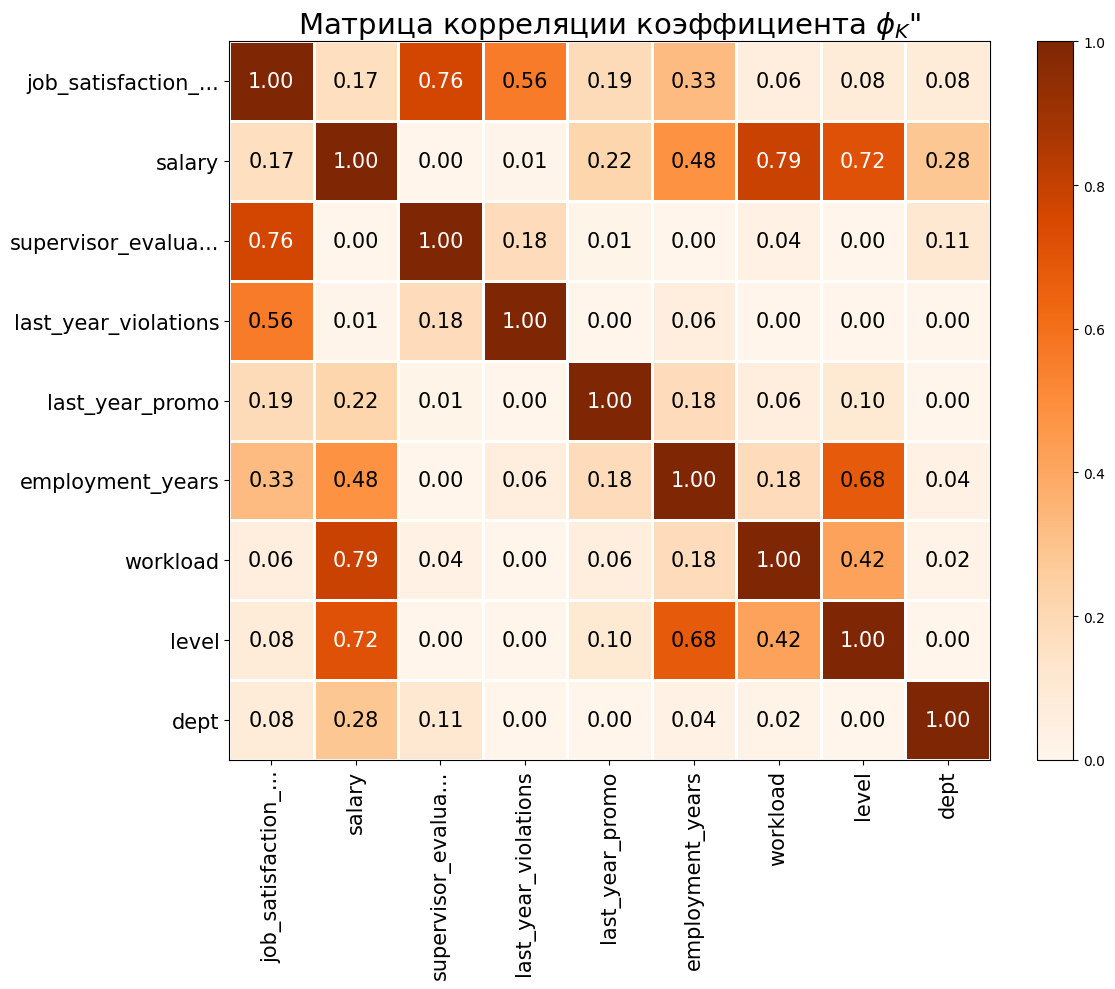

In [148]:
data=train.set_index('id')
# Вычисление корреляционной матрицы коэффициента Фи
interval_cols = interval_cols=['salary', 'job_satisfaction_rate']
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

# Построение тепловой карты для визуализации корреляционной матрицы

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэффициента $\phi_K$"',
    fontsize_factor=1.5,
    figsize=(12, 10)
)
plt.show()

Анализ корреляционной матрицы показал, что большинство значений коэффициентов корреляции находятся в допустимых пределах, что указывает на отсутствие значительной линейной зависимости между признаками. Лишь в редких случаях значения корреляции приближаются к 0.7. Вот некоторые, из таких признаков:
Признак зарплата имеет высокую положительную линейную взаимосвязь с такими признаками, как уровень занимаемой должности и уровень загруженности сотрудника. Также, достаточно заметная взаимосвязь между признаками оценка качества работы сотрудника и уровень удовлетворённости сотрудника работой. И между признаками уровень занимаемой должности и признаком длительность работы в компании. Не будем избавляться от признаков, потому что данные выглядят вполне нормально. Данные признаки обеспечивают стабильность и интерпретируемость для наших дальнейших моделей машинного обучения.

Итак, после третьего этапа нашей работы можно сделать следующие выводы:

Мы провели исследовательский анализ данных для каждой таблицы и изучили все признаки. Распределение данных в тестовой и тренировочной выборках практически идентичное.

1) Количественные признаки:

 - Длительность работы в компании (employment_years): Люди работают в компании от 1 до 10 лет, и в обеих выборках большая часть сотрудников работает в компании не более 3 лет. Наблюдаем снижение числа сотрудников с увеличением стажа. Не выявлено выбросов, данные выглядят нормально.

 - Оценка качества работы сотрудника (supervisor_evaluation): Оценка качества работы сотрудника, которую дал руководитель, варьируется от 1 до 5 и больше всего оценки 4. Данные не показывают аномалий, выбросов нет.

 - Ежемесячная зарплата сотрудника (salary): Зарплаты сотрудников в обоих случаях варьируются от 12,000 до 100,000, и большинство получает около 34,000. Выбрасов в данных не наблюдается.

 - Уровень удовлетворённости сотрудника работой в компании (job_satisfaction_rate): Значения варьируются от 0.03 до 1.0. Распределение похоже на нормальное, со сдвигом вправо, без аномальных значений.

2) Категориальные признаки:

 - Отдел, в котором работает сотрудник (dept): Наибольшее количество сотрудников работает в отделе, связанном с продажами. Меньше всего hr-работников.

 - Уровень занимаемой должности (level): Большинство сотрудников занимают должности Junior и Middle, меньшая часть — Senior.

 - Уровень загруженности сотрудника (workload): Большинство сотрудников имеют средний уровень загруженности. Около 30% сотрудников работают с низкой загрузкой.

 - Повышение за последний год (last_year_promo): Всего 3% сотрудников получили повышение за последний год.

 - Нарушения трудового договора за последний год (last_year_violations): Нарушения были у 13-14% сотрудников.

Корреляционный анализ:

Анализ корреляционной матрицы показал, что большинство значений коэффициентов корреляции находятся в допустимых пределах, что указывает на отсутствие значительной линейной зависимости между признаками. Лишь в редких случаях значения корреляции приближаются к 0.7. У признака зарплата (salary) высокая положительная взаимосвязь с уровнем занимаемой должности и уровнем загруженности сотрудника.
Заметная взаимосвязь между признаками оценка качества работы (supervisor_evaluation) и уровень удовлетворенности (job_satisfaction_rate).
Также прослеживается некоторая взаимосвязь между признаками уровень занимаемой должности (level) и длительность работы в компании (employment_years).
Мы не удаляли выбросы, так как данные выглядят нормально и не содержат отрицательных или аномальных значений. Эти признаки сохраняют стабильность и интерпретируемость для наших дальнейших моделей машинного обучения.

## Шаг 4. Подготовка данных

Для начала, перед обучением моделей, нам необходимо подготовить данные, и в этом нам помогут пайплайны. Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования.

Разобьем данные на количественные и категориальные:

Три признака: dept (отдел),'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — нужно кодировать с помощью OneHotEncoder. Два признака: level (уровень должности) и workload (уровень загруженности) — нужно кодировать с помощью OrdinalEncoder.
Остальные количественные признаки нужно масштабировать.

Целевой признак — 'job_satisfaction_rate' (удовлетворённость сотрудника работой в компании)

Создадим пайплайн

In [149]:
ohe_columns = ['dept', 'last_year_violations', 'last_year_promo']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [150]:
#OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [151]:
#ORD
categories = [['junior', 'middle', 'senior'], ['low', 'medium', 'high']]

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=categories,
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [152]:
# Преобразователи для числовых данных
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

Объединяем шаги подготовки. Применим инструмент ColumnTransformer — он объединяет операции по подготовке данных.

In [153]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [154]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

Разобьем данные тренировочной выборки и уберем столбец id:

In [155]:
train_no_id = train.drop(['id'], axis=1)

X_train = train_no_id.drop(['job_satisfaction_rate'], axis=1)
y_train = train_no_id['job_satisfaction_rate']

X_train.shape

(4000, 8)

Тестовую выборку сначала соединим, чтобы данные целевого признака шли в том же порядке, что и во входных признаках. Для этого соединим таблицы по id.

In [156]:
display(y_test_1.head(5))

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [157]:
test = X_test.merge(y_test_1, on='id')

In [158]:
X_test = test.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test['job_satisfaction_rate']

X_test.shape

(2000, 8)

На этом этапе мы выполнили следующие действия:

Подготовка данных к обучению моделей:

 - Разделили данные на количественные и категориальные признаки.
 - Определили, какие признаки требуют масштабирования, а какие кодирования.

Разделение признаков для кодирования и масштабирования:

 - Три признака: 'dept' (отдел), 'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — закодировали с помощью OneHotEncoder.
 - Два признака: 'level' (уровень должности) и 'workload' (уровень загруженности) — закодировали с помощью OrdinalEncoder.
 - Остальные количественные признаки подвергли масштабированию.

Определили, что целевым признаком является 'job_satisfaction_rate' (удовлетворённость сотрудника работой в компании). Также мы разделили данные тренировочной выборки и объединили тестовую выборку по 'id'.
После, создали пайплайн, который включает все шаги по подготовке данных (кодирование, масштабирование, обработка пропусков). Применили инструмент ColumnTransformer, который объединяет операции по подготовке данных.

Итак, на этом этапе мы провели всестороннюю подготовку данных, включая кодирование категориальных признаков, масштабирование количественных признаков и обработку пропусков, используя пайплайн. Теперь наши данные готовы для обучения моделей.

## Шаг 5. Обучение моделей

В нашем исследовании обучим две модели: одну модель линейной регрессии (LinearRegression), а в качестве второй — дерево решений (DecisionTreeRegression). Также подберем гиперпараметры к моделям.

DecisionTreeRegressor и LinearRegression представляют два разных подхода к моделированию данных. Эти модели дополняют друг друга, позволяя исследовать данные с разных сторон. Дерево решений может выявить нелинейные зависимости, которые линейная регрессия может пропустить, и наоборот. Использование этих двух моделей позволяет получить более полное и глубокое понимание данных, а также выбрать наиболее подходящую модель для задачи предсказания удовлетворенности сотрудников работой.

In [159]:
param_grid = [
    
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 15),
        'model__min_samples_split': range(2, 15),
        'model__min_samples_leaf': range(1, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
    {
        'model': [LinearRegression()],
        'model__fit_intercept':[True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Для оценки качества моделей напишем функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE (симметричное среднее абсолютное процентное отклонение). Используем эту метрику при подборе гиперпараметров и оценке качества моделей.
Выбор SMAPE для оценки уровеня удовлетворённости сотрудника обоснован её способностью учитывать относительную ошибку в процентном соотношении, симметричность в оценке и легкость интерпретации результатов, что соответствует нашим целям построения эффективной и понятной модели прогнозирования.

In [160]:
#Создаем собственную метрику
def SMAPE (y_true, y_pred):
 
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
 
    return 100 * np.mean(numerator / denominator)
 
smape_scorer = make_scorer(SMAPE, greater_is_better= False)

Обучим модель, выберем лучшую модель и проверим её качество на основе новой метрики — SMAPE

In [161]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring=smape_scorer,
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=4000
)

random_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', random_search.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 14, 'model': DecisionTreeRegressor(random_state=42)}
Метрика лучшей модели на тренировочной выборке: -14.482156603603448


Лучшей моделью получилась модель дерево решений с максимальной глубиной - 14, минимальным количеством образцов для разбиения узла - 2, минимальным количеством образцов в листовом узле - 3

Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику SMAPE.

Как мы видим, метрика лучшей модели на тренировочной выборке получилась равна -14.48. Когда метрика используется в GridSearchCV или RandomizedSearchCV, они по умолчанию пытаются максимизировать значение метрики. Однако, для метрик, которые нужно минимизировать (например как в нашем случае, SMAPE), используется параметр greater_is_better=False в make_scorer. Это делает метрику отрицательной, чтобы RandomizedSearchCV могли минимизировать её.

Вот почему после выполнения поиска гиперпараметров, чтобы получить настоящие значения метрики, мы умножаем результат на -1.

In [162]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_*-1)
y_pred = random_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {SMAPE(y_test, y_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'last_year_violations',
                                                   'last_year_promo']),
                                  

Критерий успеха: SMAPE ≤ 15 на тестовой выборке. Наша метрика SMAPE на тестовой выборке получилась равной 13.63, что даже лучше, чем на тренировочной выборке. Это указывает на высокое качество работы модели и значит наша модель работает хорошо, поскольку она показывает стабильные и точные результаты при прогнозировании на новых данных. Такая производительность подтверждает, что наша модель не только хорошо обучена, но и обладает отличной обобщающей способностью, что делает её пригодной для реальных бизнес-задач.

По итогу 5 шага нашей работы, можно сделать небольшое обобщение проделанного.

Для начала мы выбрали для обучения две модели: линейную регрессию (LinearRegression) и дерево решений (DecisionTreeRegressor), и подобрали для них гиперпараметры.

DecisionTreeRegressor и LinearRegression были выбраны для исследования, потому что они представляют разные подходы к моделированию данных. Дерево решений способно выявлять нелинейные зависимости, которые могут быть пропущены линейной регрессией, и наоборот. Использование обеих моделей позволило получить более полное понимание данных и выбрать наилучшую модель для предсказания уровня удовлетворенности сотрудников.

Лучшей моделью стало дерево решений с максимальной глубиной 14, минимальным количеством образцов для разбиения узла 2 и минимальным количеством образцов в листовом узле 3.

Для поиска наилучших параметров моделей и для оценки качества моделей мы использовали метрику SMAPE (симметричное среднее абсолютное процентное отклонение с целью достижения наилучшего прогностического качества. Проверка на тестовой выборке показала, что метрика SMAPE составила 13.63, что лучше, чем на тренировочной выборке. Это свидетельствует о высоком качестве работы модели и её способности показываать стабильные и точные результаты при прогнозировании на новых данных.

Таким образом, наша модель демонстрирует хорошие результаты, делая её эффективным инструментом для прогнозирования удовлетворенности сотрудников для нашей задачи.

## Шаг 6. Оформление выводов

Нашей первой задачей было построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Т.к. удовлетворённость работой напрямую влияет на отток сотрудников, его предсказание очень важно для компании, потому что внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Исходя из результатов нашего исследования, можно сделать промежуточные выводы о том, какая из выбранных моделей — линейная регрессия (LinearRegression) или дерево решений (DecisionTreeRegressor) — справилась лучше.

Дерево решений показало лучше результат на тестовой выборке по метрике SMAPE, чем линейная регрессия. SMAPE для дерева решений составила 13.63, что меньше нашего критерия успеха. Это указывает на то, что дерево решений смогло лучше уловить нелинейные зависимости в данных, что было важно для предсказания уровня удовлетворённости сотрудников.

Вероятно дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров. Также, возможной причиной, почему дерево решений оказалось лучшей моделью может быть в том, что дерево решений способно автоматически выявлять и учитывать нелинейные зависимости между признаками, что может быть пропущено линейной регрессией. Глубина дерева и другие гиперпараметры были настроены таким образом, чтобы модель могла достаточно точно адаптироваться к специфике наших данных, что повлияло на более точные прогнозы. Также, линейная регрессия, несмотря на свою простоту и интерпретируемость, может быть менее эффективной в моделировании данных с комплексными нелинейными взаимосвязями, как в нашем случае.

И поэтому, исходя из сравнения производительности моделей, дерево решений оказалось предпочтительным выбором для нашей задачи предсказания уровня удовлетворённости сотрудников. Его способность улавливать сложные взаимосвязи в данных позволила достичь более точных результатов на тестовой выборке по сравнению с линейной регрессией. Это подчеркивает важность выбора модели, которая наилучшим образом соответствует особенностям и требованиям конкретной задачи в области прогнозирования.

# Задача 2: предсказание увольнения сотрудника из компании

Во второй части работы перед нами стоит задача построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Шаг 1. Загрузка данных

Загрузим данные с новым признаком и посмотрим общую информацию.

In [163]:
train_2 = pd.read_csv('train_quit.csv')
X_test_2 = pd.read_csv('test_features.csv')
y_test_2 = pd.read_csv('test_target_quit.csv')

In [164]:
display(train_2.head(5))
train_2.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [165]:
display(X_test_2.head(5))
X_test_2.info()
print(len(X_test_2))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
2000


In [166]:
display(y_test_2.head(5))
y_test_2.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Как и в задаче выше, в тренировочной выборке содержится 4000 строк, в тестовой выборке с входными данными 2000 строк, в тестовой выборке с целевым признаком также 2000 строк. Как мы сразу можем заметить в исходном датафрейме X_test_2 присутствуют пропуски в столбцах 'dept' и 'level'. Также, во всех столбцах используется корректный тип данных.

## Шаг 2. Предобработка данных

Далее займемся предобработкой исходных данных. В данных присутствуют пропуски, но их обработкой займемся чуть позже, на этапе работы с пайплайном. После произведем проверку наших датасетов на наличие полных дубликатов.

In [167]:
print(train_2.duplicated().sum())
print(X_test_2.duplicated().sum())
print(y_test_2.duplicated().sum())

0
0
0


Полных дубликатов не обнаружено, проверим на наличие неявных дубликатов

In [168]:
print(train_2['id'].value_counts())
print(X_test_2['id'].value_counts())
print(y_test_2['id'].value_counts())

id
723290    1
935224    1
255062    1
498348    1
572514    1
         ..
495106    1
116005    1
265874    1
855596    1
853842    1
Name: count, Length: 4000, dtype: int64
id
485046    1
754136    1
862904    1
734514    1
160031    1
         ..
959945    1
549540    1
969698    1
790117    1
771859    1
Name: count, Length: 2000, dtype: int64
id
999029    1
731336    1
753322    1
130715    1
373731    1
         ..
463616    1
835978    1
594334    1
217807    1
460332    1
Name: count, Length: 2000, dtype: int64


Также, нужно убедиться, что в новых данных нет ошибок и аномальных значений.

In [169]:
# для датасета train_2
print(train_2['dept'].unique())
print(train_2['level'].unique())
print(train_2['workload'].unique())
print(train_2['last_year_promo'].unique())
print(train_2['last_year_violations'].unique())
print(train_2['quit'].unique())

# для датасета X_test_2
print(X_test_2['dept'].unique())
print(X_test_2['level'].unique())
print(X_test_2['workload'].unique())
print(X_test_2['last_year_promo'].unique())
print(X_test_2['last_year_violations'].unique())

# для датасета y_test_2
print(y_test_2['quit'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']
['yes' 'no']


Как мы можем заметить, в тестовой выборке есть пустые значения. Заменим их в этих колонках на NaN, как и делали в прошлой задаче

In [170]:
# Заменим пустые строки на NaN
X_test_2.replace(' ', np.nan, inplace=True)

# Проверим наше преобразование
print(X_test_2['dept'].unique())
print(X_test_2['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


Также, перепроверим наименование столбцов.

In [171]:
print(train_2.columns.tolist())
print(X_test_2.columns.tolist())
print(y_test_2.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit']
['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
['id', 'quit']


Во 2 шаге 2ой задачи мы начали предобработку исходных данных. Обнаружив пропуски, решили отложить их обработку до этапа работы с пайплайном. Затем проверили наши датасеты на наличие полных дубликатов и не нашли их. Проверка на наличие неявных дубликатов также не выявила дубликатов в данных. Далее мы проверили категориальные признаки на наличие ошибок и перепроверили наименование столбцов. Как и в прошлой задаче нашли пустые значения в двух колонках тестовой выборки и заменили их на NaN. Все данные оказались корректными. В новых колонках quit в тренировочной и тестовой выборках ошибок не обнаружено.

## Шаг 3. Исследовательский анализ данных

Т.к. входные признаки тестовой выборки (X_test_2) те же, что и в прошлой задаче, произведем исследовательский анализ данных для тренировочной выборки (train_2) и целевого признака тестовой выборки (y_test_2) и исследуем все их признаки.

К количественным признакам:

в датафрейме train_2 относятся такие признаки, как 'employment_years', 'supervisor_evaluation', 'salary'   
в датафрейме y_test_2 их нет.

К категориальным признакам относятся:

в датафрейме train_2 относятся такие признаки, как 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit'   
в датафрейме y_test_2 это 'quit'

Построим графики по количественным признакам — гистограмму частотности распределения и ящик с усами для каждого признака

In [172]:
display(train_2[['employment_years', 'supervisor_evaluation', 'salary']].describe().T)

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0


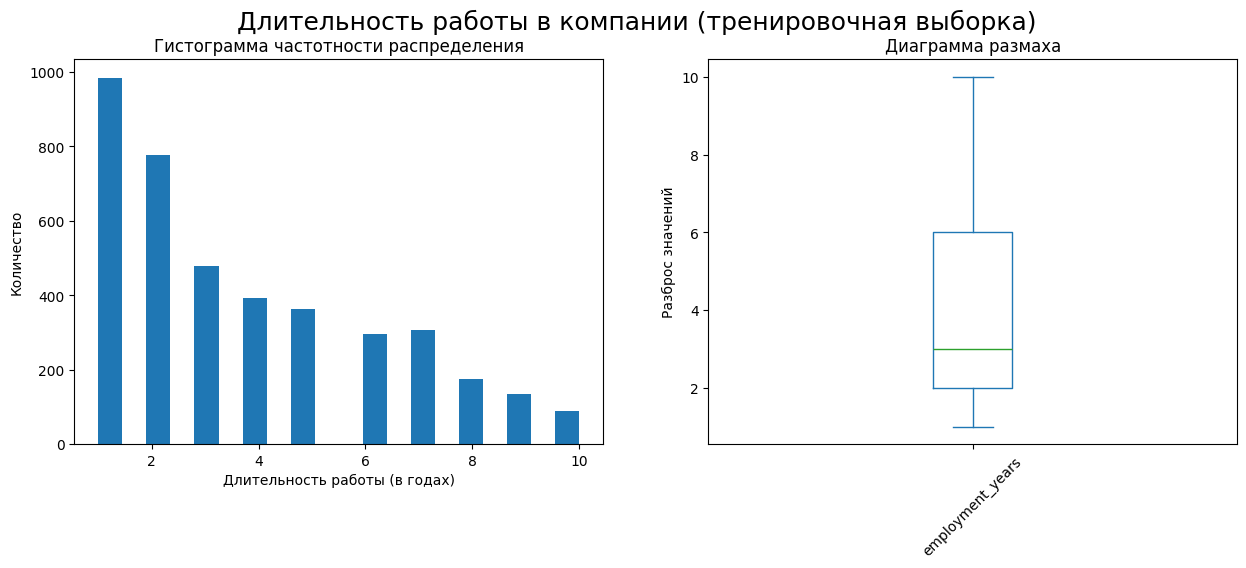

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Длительность работы в компании (тренировочная выборка)', fontsize=18)
train_2['employment_years'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Длительность работы (в годах)')
axes[0].set_ylabel('Количество')

train_2['employment_years'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Как и в прошлой задаче, по диаграмме видно, что люди работают в компании от 1 до 10 лет, причем в обоих случаях большая часть сотрудников работает в компании не более 3 лет. Также можно заметить, что с увеличением стажа в компании количество сотрудников снижается. Выбрасов никаких не наблюдается.

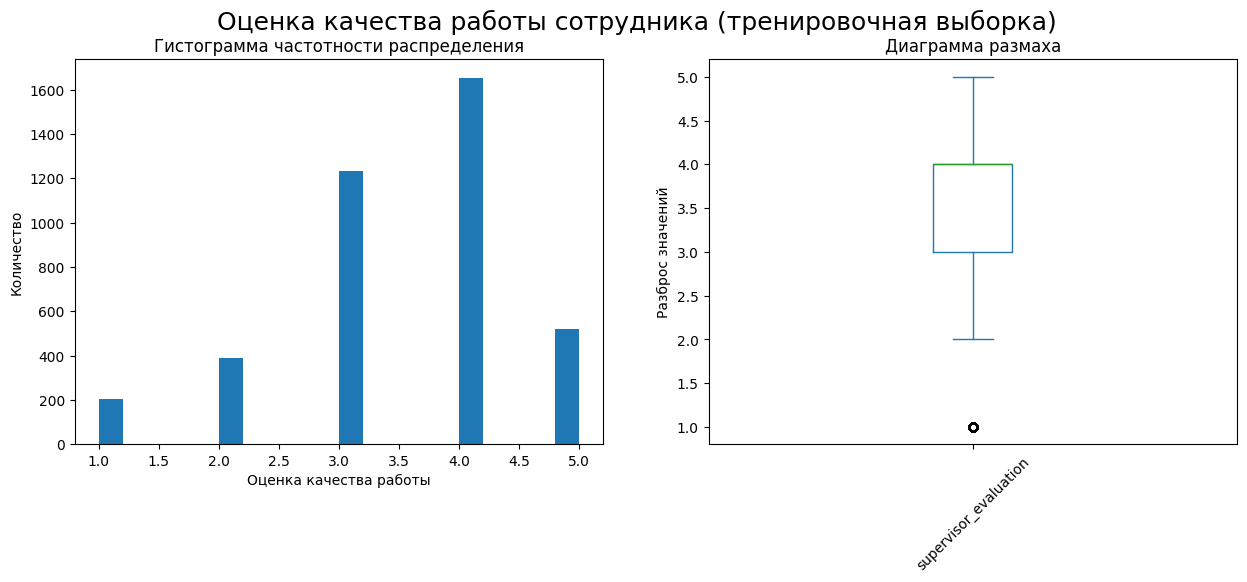

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Оценка качества работы сотрудника (тренировочная выборка)', fontsize=18)
train_2['supervisor_evaluation'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Оценка качества работы')
axes[0].set_ylabel('Количество')

train_2['supervisor_evaluation'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные выглядят вполне адекватными, поэтому не будем избавляться от выбрасов. Оценка качества работы сотрудника, которую дал руководитель, варьируется как и в задаче выше от 1 до 5 и больше всего оценки 4.

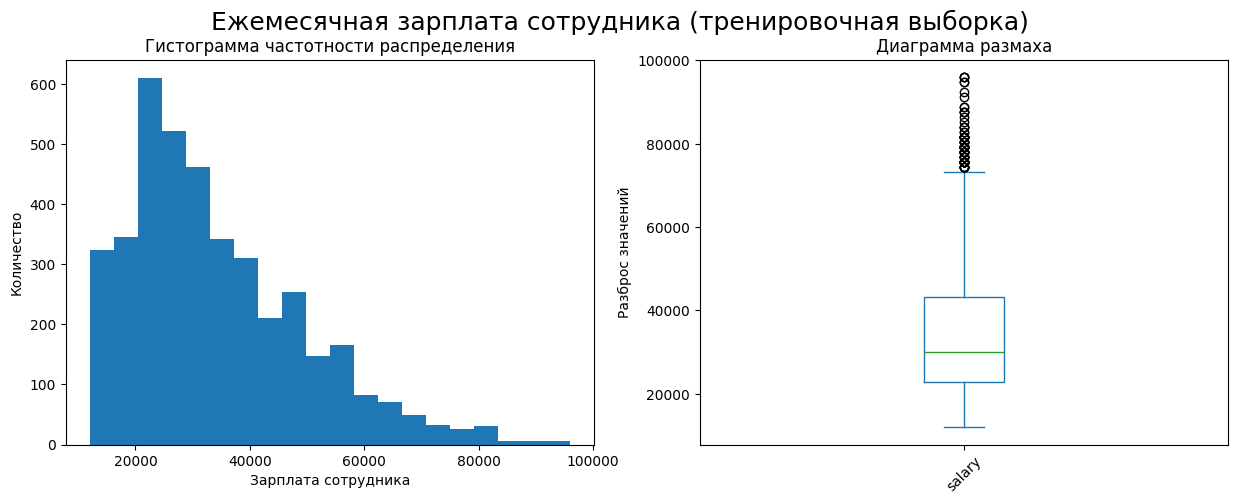

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Ежемесячная зарплата сотрудника (тренировочная выборка)  ', fontsize=18)
train_2['salary'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Зарплата сотрудника')
axes[0].set_ylabel('Количество')

train_2['salary'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Мы не будем избавляться от выбросов, так как данные выглядят нормально. В ежемесячной зарплате сотрудников график имеет вид нормального распределения со сдвигом влево. Зарплаты сотрудников варьируются от 12,000 до 96,000, и большинство получает около 30,000.

Далее рассмотрим категориальные признаки.
Построим круговые диаграммы по каждому признаку для тренировочной выборки (train_2) и для целевого признака тестовой выборки (y_test_2).

1) Признаки - dept, level, workload, last_year_promo, last_year_violations

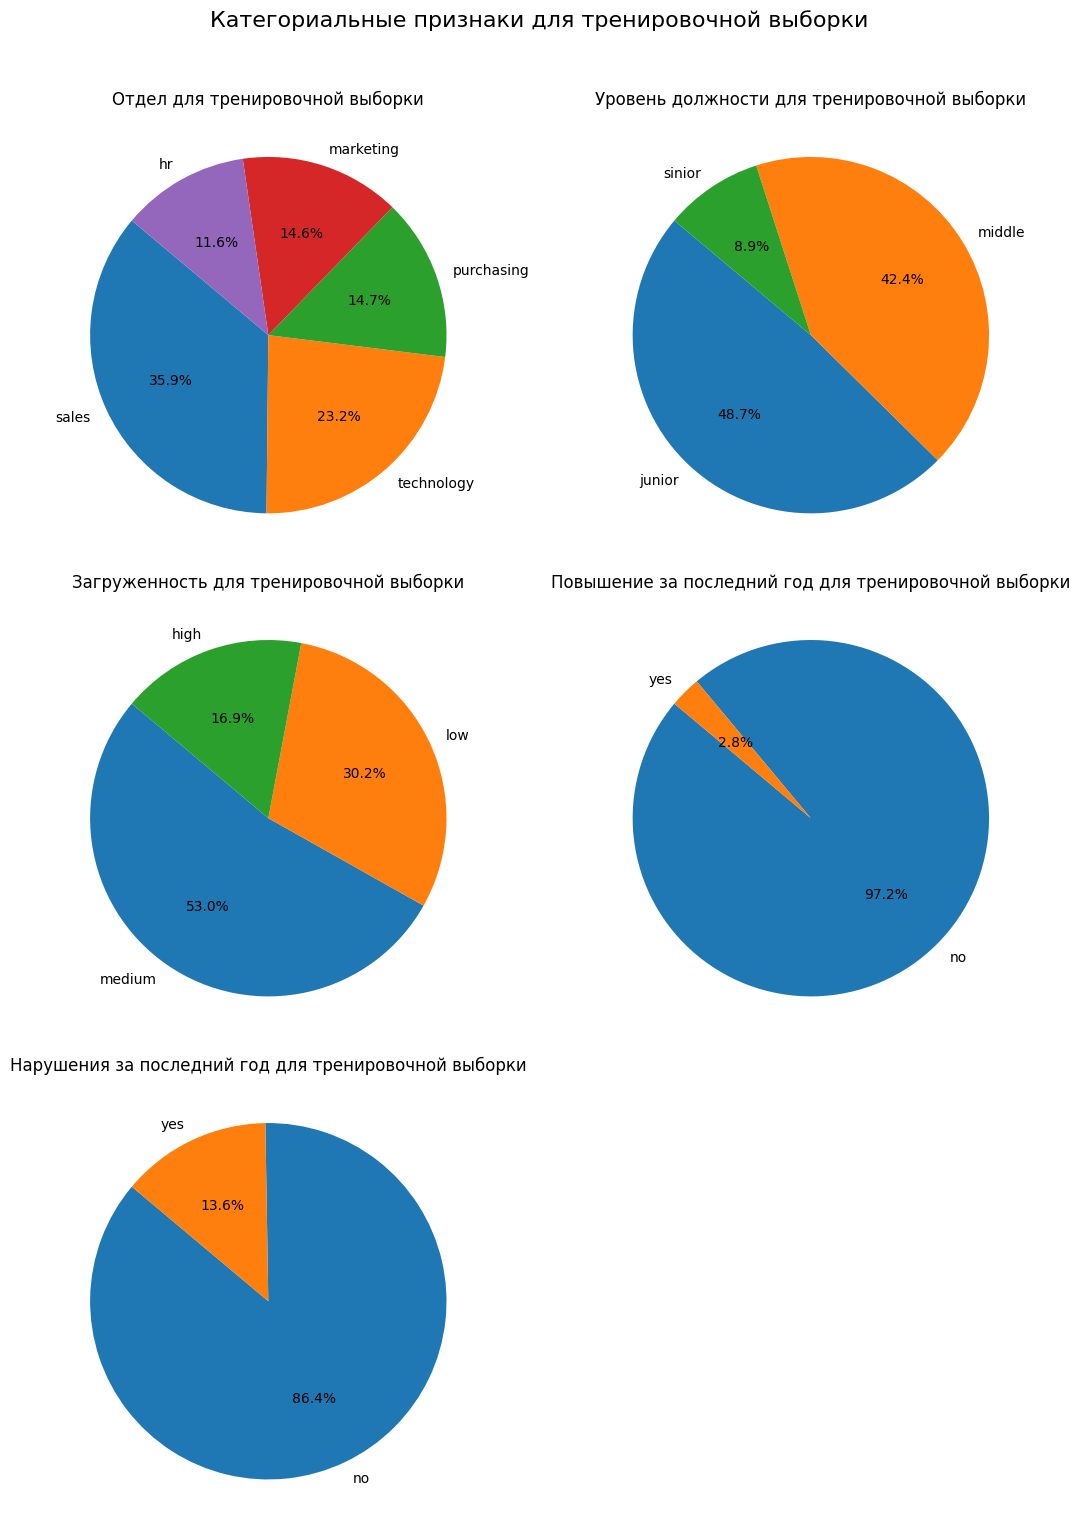

In [176]:
train_2_dept_counts = train_2['dept'].value_counts()
train_2_level_counts = train_2['level'].value_counts()
train_2_workload_counts = train_2['workload'].value_counts()
train_2_last_year_promo_counts = train_2['last_year_promo'].value_counts()
train_2_last_year_violations_counts = train_2['last_year_violations'].value_counts()

# Подготовка данных для графика
labels_train_2_dept = train_2_dept_counts.index
sizes_train_2_dept = train_2_dept_counts.values

labels_train_2_level = train_2_level_counts.index
sizes_train_2_level = train_2_level_counts.values

labels_train_2_workload = train_2_workload_counts.index
sizes_train_2_workload = train_2_workload_counts.values

labels_train_2_last_year_promo = train_2_last_year_promo_counts.index
sizes_train_2_last_year_promo = train_2_last_year_promo_counts.values

labels_train_2_last_year_violations = train_2_last_year_violations_counts.index
sizes_train_2_last_year_violations = train_2_last_year_violations_counts.values


fig, axes = plt.subplots(3, 2, figsize=(11, 15))

# Круговая диаграмма для Отдела
axes[0, 0].pie(sizes_train_2_dept, labels=labels_train_2_dept, autopct='%1.1f%%', startangle=140)
axes[0, 0].set_title('Отдел для тренировочной выборки')

# Круговая диаграмма для Уровня должности
axes[0, 1].pie(sizes_train_2_level, labels=labels_train_2_level, autopct='%1.1f%%', startangle=140)
axes[0, 1].set_title('Уровень должности для тренировочной выборки')

# Круговая диаграмма для Загруженности
axes[1, 0].pie(sizes_train_2_workload, labels=labels_train_2_workload, autopct='%1.1f%%', startangle=140)
axes[1, 0].set_title('Загруженность для тренировочной выборки')

# Круговая диаграмма для Повышения за последний год
axes[1, 1].pie(sizes_train_2_last_year_promo, labels=labels_train_2_last_year_promo, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title('Повышение за последний год для тренировочной выборки')

# Круговая диаграмма для Нарушений за последний год
axes[2, 0].pie(sizes_train_2_last_year_violations, labels=labels_train_2_last_year_violations, autopct='%1.1f%%', startangle=140)
axes[2, 0].set_title('Нарушения за последний год для тренировочной выборки')

# Удаление пустого подграфика
fig.delaxes(axes[2, 1])

# Настройка общего заголовка и компоновки
plt.suptitle("Категориальные признаки для тренировочной выборки", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Значения выборок практически идентичны, со значениями, которые были в 1 задаче. Больше всего сотрудников в компании на должности связанной с продажами. Меньше всего hr-работников. В компании очень много людей занимают должность junior и middle и менее 10 процентов сотрудников занимают должность sinior. По загруженности больше всего сотрудников со средним уровнем загруженности. Также около 30% сотрудников имеют низкую загруженность. К тому же, как видно из данных графиков, повышение было примерно у 3% сотрудников из всего штата. Нарушения трудового договора выявлены у 13% сотрудников.

2) Отдельно выведем признак - Увольнение сотрудника из компании - 'quit'

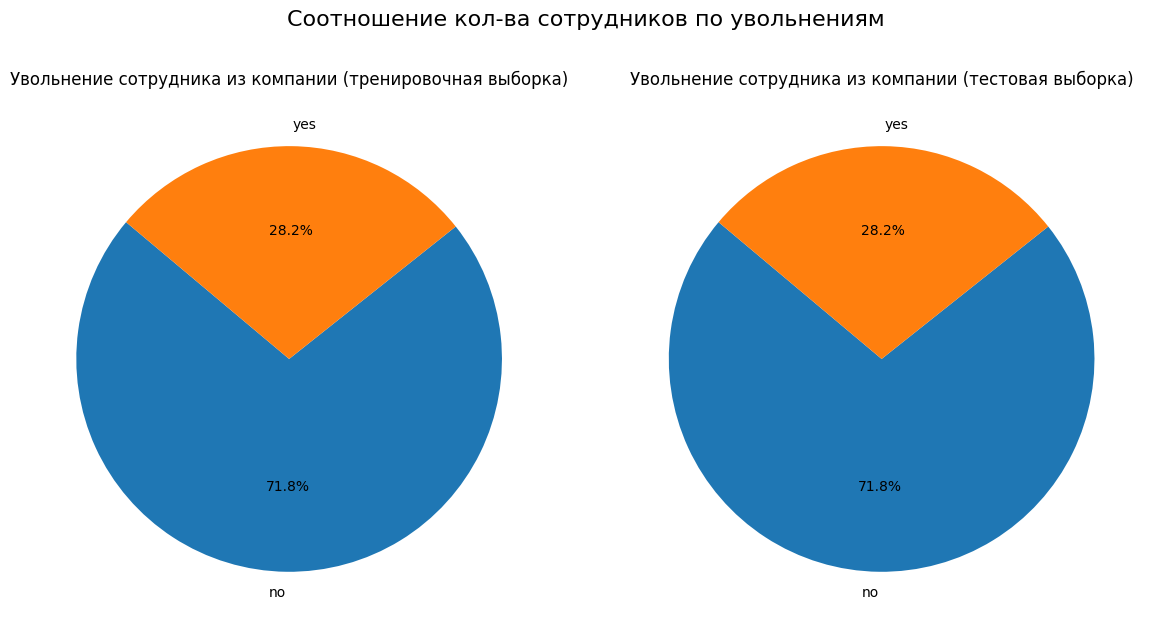

In [177]:
# Подсчёт значений для каждого типа сервиса в двух сегментах
train_2_quit_counts = train_2['quit'].value_counts()
y_test_2_quit_counts = y_test_2['quit'].value_counts()
# Подготовка данных для графика
labels_train = train_2_quit_counts.index
sizes_train = train_2_quit_counts.values

labels_y_test = y_test_2_quit_counts.index
sizes_y_test = y_test_2_quit_counts.values

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Круговая диаграмма для тренировочной выборки
axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Увольнение сотрудника из компании (тренировочная выборка)')

# Круговая диаграмма для тестовой выборки
axes[1].pie(sizes_y_test, labels=labels_y_test, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Увольнение сотрудника из компании (тестовая выборка)')

plt.suptitle("Соотношение кол-ва сотрудников по увольнениям", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Мы видим, что уволенных сотрудников 28% от общего количества работников. В тренировочной и тестовой выборках число уволенных сотрудников одинаковое.

Далее, попробуем составить портрет «уволившегося сотрудника». Узнаем, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности.

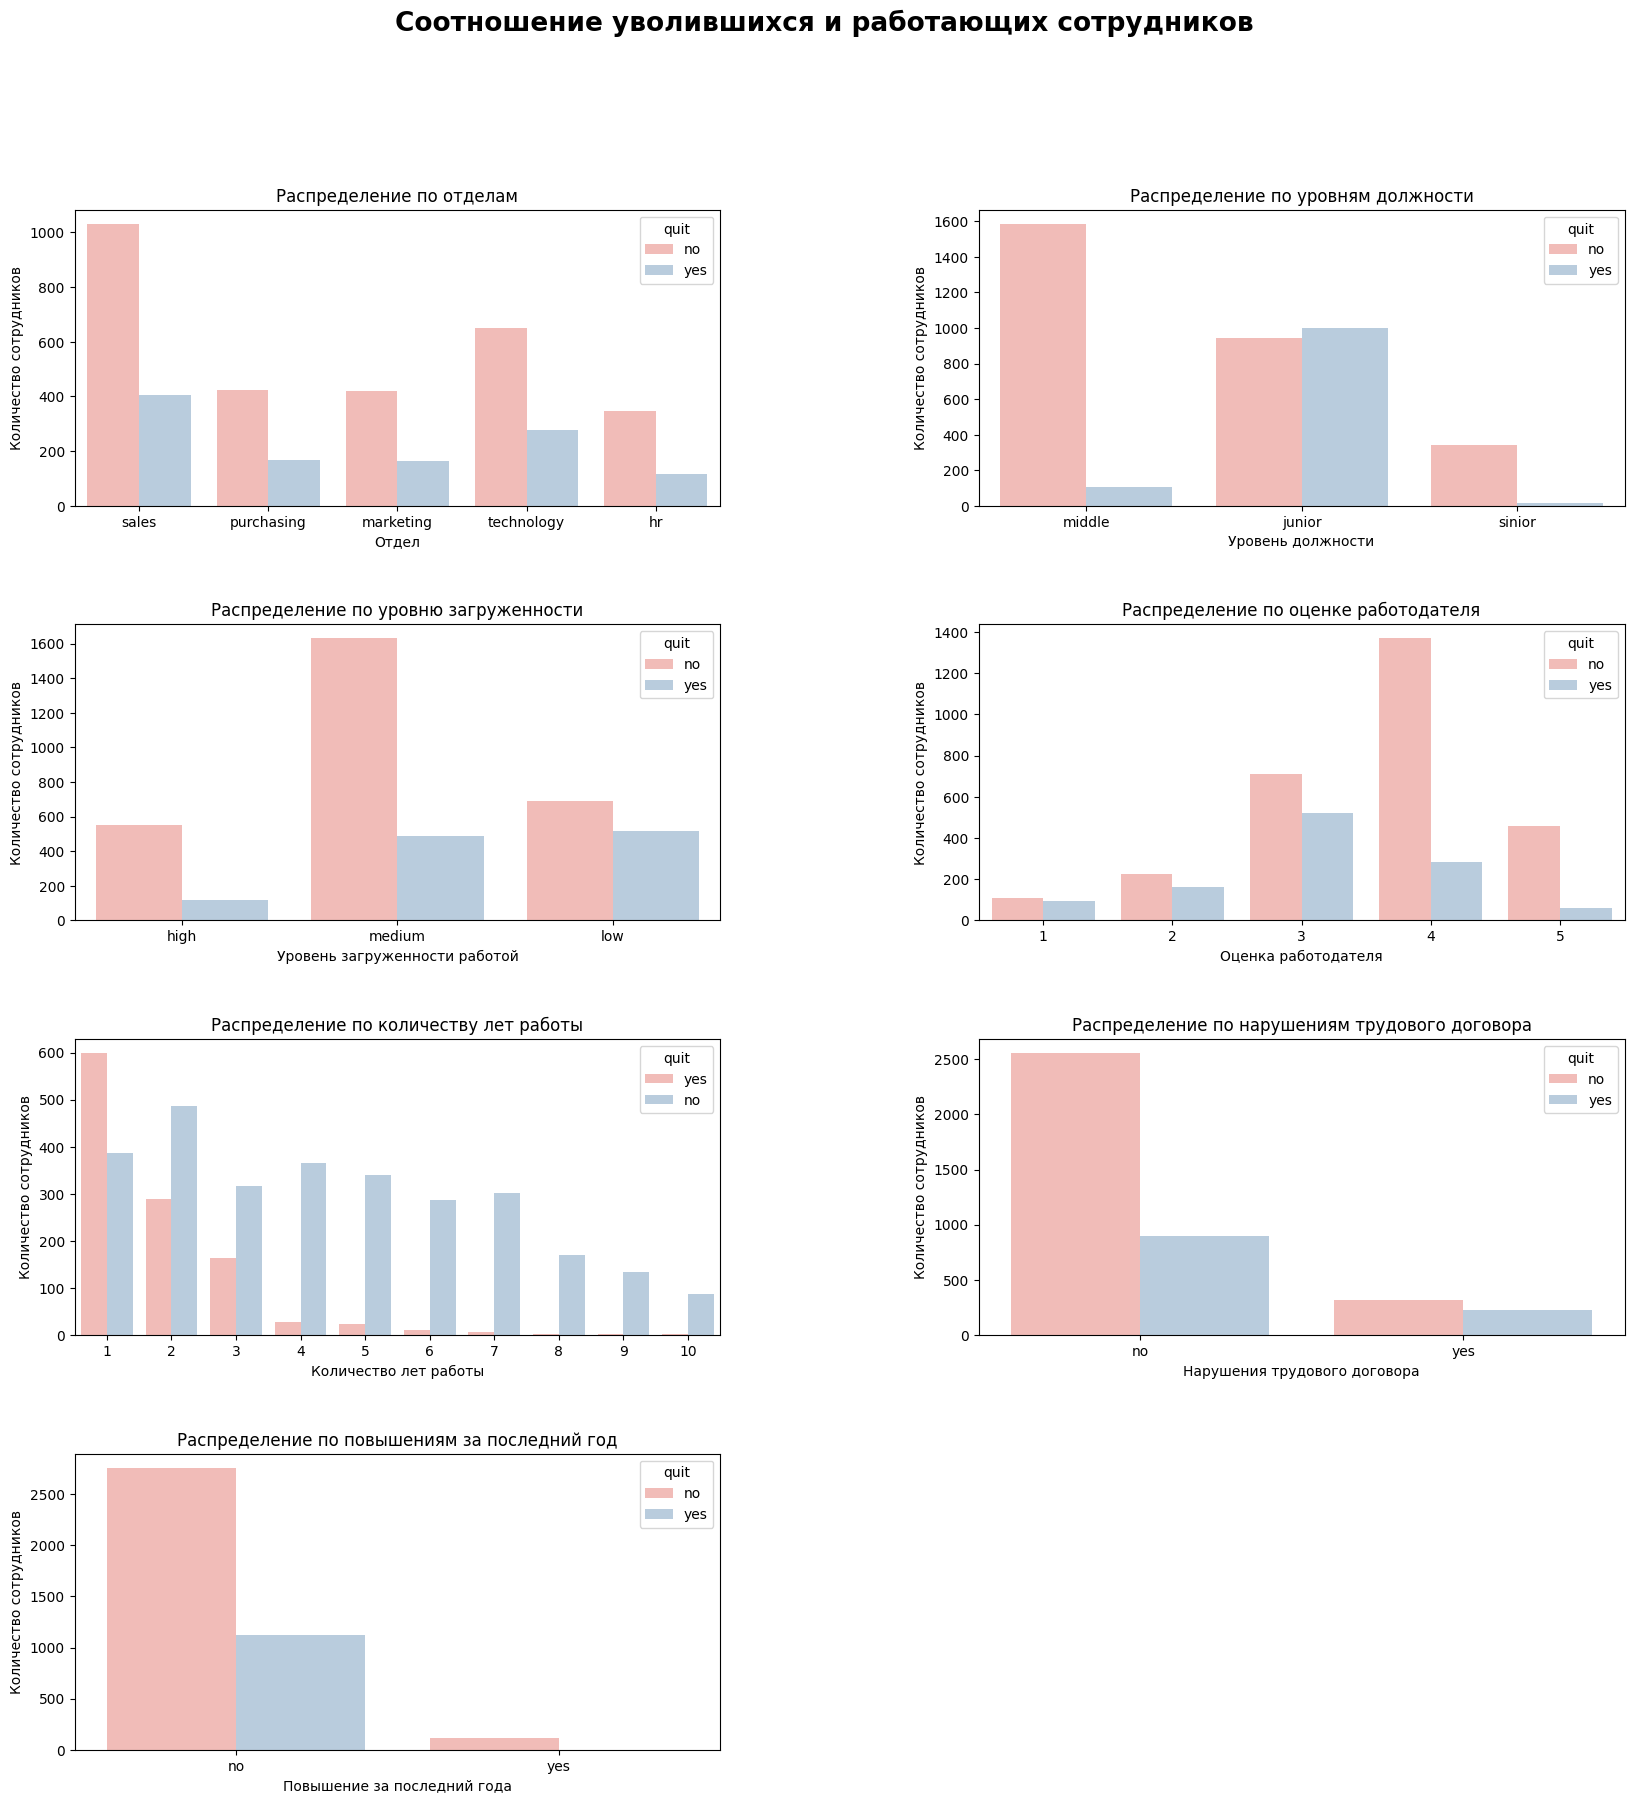

In [178]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')

sns.countplot(x ='dept', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[0,0]).set(xlabel='Отдел', ylabel='Количество сотрудников');
axes[0,0].set_title('Распределение по отделам')

sns.countplot(x ='level', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Количество сотрудников');
axes[0,1].set_title('Распределение по уровням должности')

sns.countplot(x ='workload', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[1,0]).set(xlabel='Уровень загруженности работой', ylabel='Количество сотрудников');
axes[1,0].set_title('Распределение по уровню загруженности')

sns.countplot(x ='supervisor_evaluation', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Количество сотрудников');
axes[1,1].set_title('Распределение по оценке работодателя')

sns.countplot(x ='employment_years', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[2,0]).set(xlabel='Количество лет работы', ylabel='Количество сотрудников');
axes[2,0].set_title('Распределение по количеству лет работы')

sns.countplot(x ='last_year_violations', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Количество сотрудников');
axes[2,1].set_title('Распределение по нарушениям трудового договора')

sns.countplot(x ='last_year_promo', data = train_2, hue = 'quit',
              palette = "Pastel1", ax=axes[3,0]).set(xlabel='Повышение за последний года', ylabel='Количество сотрудников');
axes[3,0].set_title('Распределение по повышениям за последний год')


# Удаление пустого подграфика
fig.delaxes(axes[3, 1])

# Настройка расстояний между графиками
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.show()

Анализируя графики, видно, что из всех отелов люди увольняются примерно равномерно, но больше всего из sales. Это может быть связано с тем, что в продажах работет самое большое количество сотрудников. Потом больше всего увольняются сотрудники с уровнем должности junior, а на должностях middle и sinior увольнений не так много. Увольнений с уровнем загрузки middle и low намного больше, чем с загрузкой high. Также сотрудников больше на увольнение, имеющие низкие оценки руководителя (от 1 до 3). На графике также хорошо видно, что большая часть уволенных сотруников проработала в компании в среднем не более 3х лет, тоесть все они были недавно работающие в компании. Среди уволивщихся сотруднников большая часть была без нарушений трудового договора, значит, скорее всего, они ушли по собственному жеданию. Но также есть уволивщиеся сотрудники, у которых есть наружение договора за последний год. И у всех уволившихся сотрудников не было повышения за послений год.

Такой результат можно объяснить несколькими факторами:

 - Сотрудники на начальных уровнях часто испытывают неуверенность в карьерных перспективах и могут быть более склонны к поиску новых возможностей, особенно если не видят быстрого карьерного роста или удовлетворения от текущей работы.
 - Сотрудники с низкой загруженностью могут чувствовать себя недооценёнными или неиспользуемыми в компании, что также может способствовать их желанию изменить место работы.
 - Низкие оценки от руководителя могут свидетельствовать о несоответствии ожиданий сотрудника и реальной ситуации в компании, что может вызывать недовольство и повышать вероятность увольнения.
 - Сотрудники, которые недавно присоединились к компании, могут ещё находиться в процессе адаптации и поиска оптимальной среды работы. Если они не находят подходящей атмосферы или возможностей для роста, они могут быстрее решиться на уход.
 - Факт отсутствия повышения среди уволившихся сотрудников может свидетельствовать о неудовлетворённости карьерными перспективами или отсутствием стимулов для долгосрочного пребывания в компании. Это может быть одним из факторов, способствующих принятию решения об уходе.

Также сравним среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

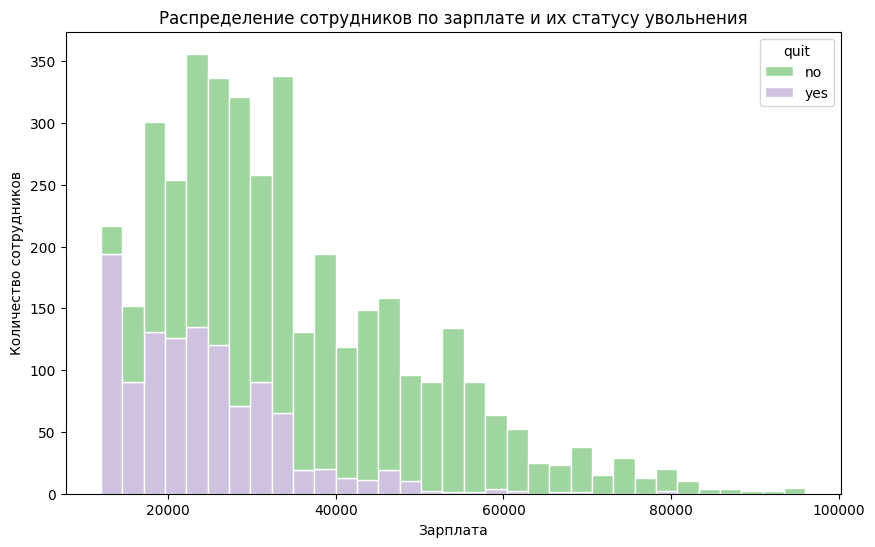

In [179]:
# Настройка размера графика
plt.figure(figsize=(10, 6))
# Построение histplot для зарплаты
sns.histplot(data=train_2, x='salary', hue='quit', palette="Accent", multiple='stack', edgecolor='white')
plt.xlabel('Зарплата')
plt.ylabel('Количество сотрудников')
plt.title('Распределение сотрудников по зарплате и их статусу увольнения')
plt.show()

In [180]:
# Фильтрация данных для ушедших сотрудников
quit_employees = train_2[train_2['quit'] == 'yes']
average_salary_quit = quit_employees['salary'].mean()

# Фильтрация данных для оставшихся сотрудников
stay_employees = train_2[train_2['quit'] == 'no']
average_salary_stay = stay_employees['salary'].mean()

print(f"Средняя зарплата ушедших сотрудников: {average_salary_quit:.2f}")
print(f"Средняя зарплата оставшихся сотрудников: {average_salary_stay:.2f}")

Средняя зарплата ушедших сотрудников: 23885.11
Средняя зарплата оставшихся сотрудников: 37702.23


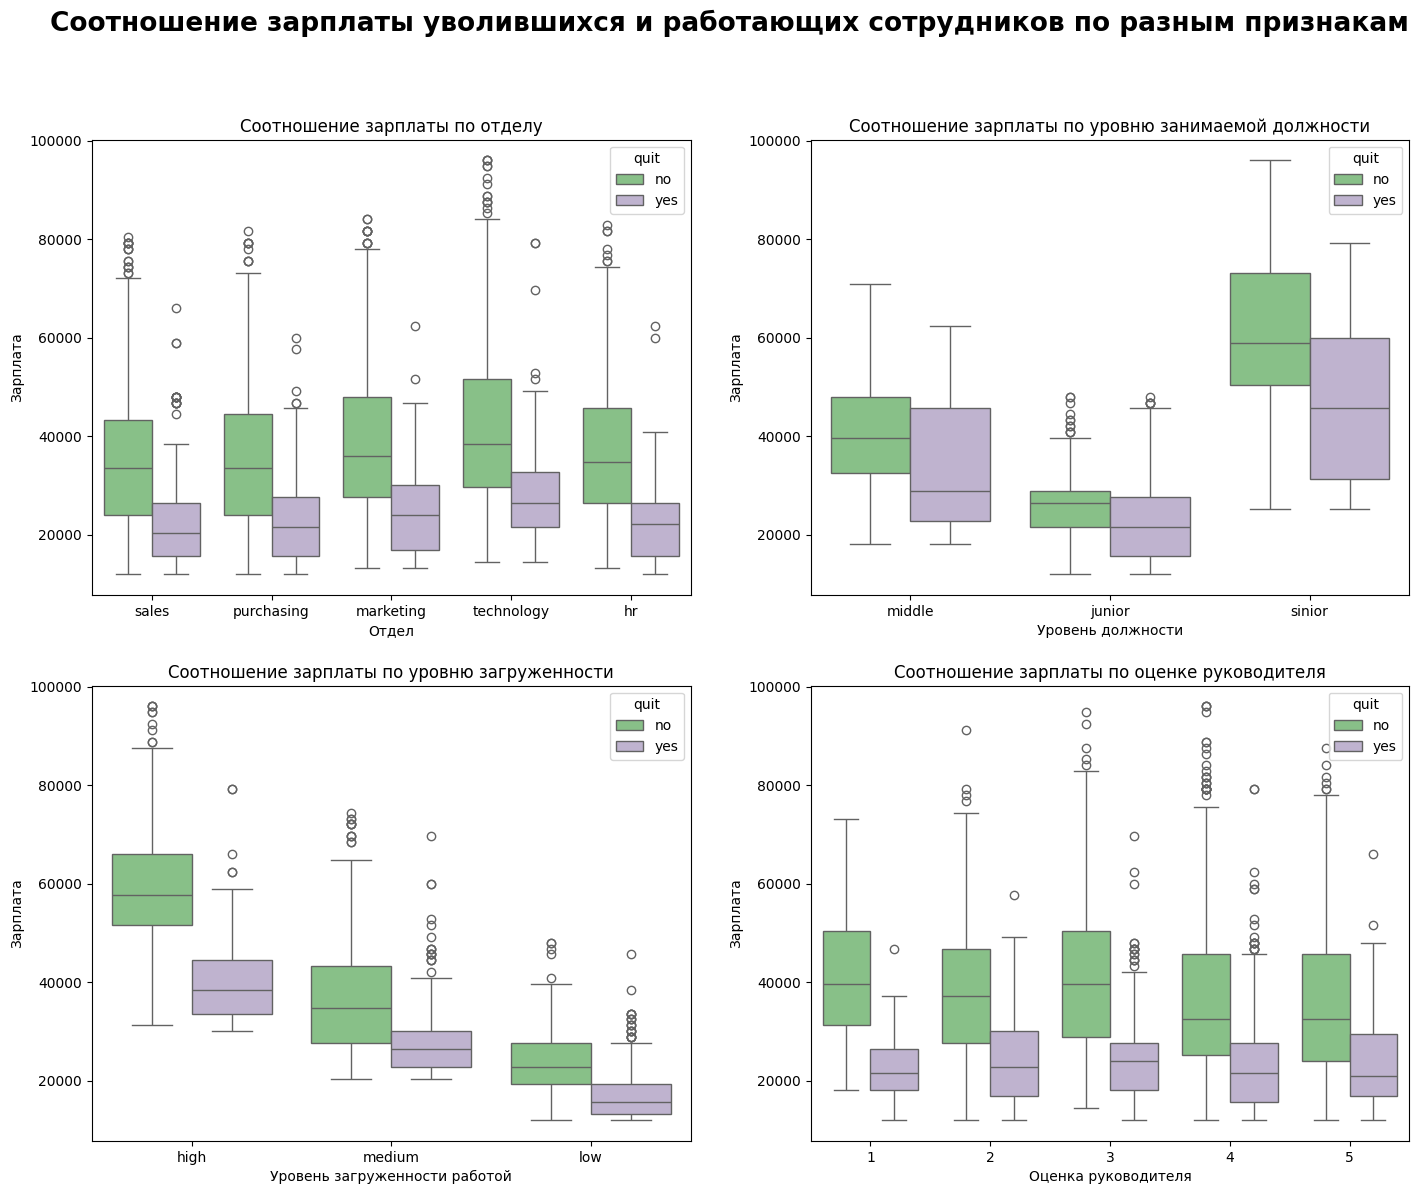

In [181]:
fig, axes = plt.subplots(2, 2, figsize=(17,13))
plt.suptitle('Соотношение зарплаты уволившихся и работающих сотрудников по разным признакам', fontsize=19, fontweight='bold')

sns.boxplot(x='dept', y='salary', hue='quit', 
            palette='Accent', data=train_2, ax=axes[0,0]).set(xlabel='Отдел', ylabel='Зарплата');
axes[0,0].set_title('Соотношение зарплаты по отделу')

sns.boxplot(x='level', y='salary', hue='quit', 
            palette='Accent', data=train_2, ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Зарплата');
axes[0,1].set_title('Соотношение зарплаты по уровню занимаемой должности')

sns.boxplot(x='workload', y='salary', hue='quit', 
            palette='Accent', data=train_2, ax=axes[1,0]).set(xlabel='Уровень загруженности работой', ylabel='Зарплата');
axes[1,0].set_title('Соотношение зарплаты по уровню загруженности')

sns.boxplot(x='supervisor_evaluation', y='salary', hue='quit', 
            palette='Accent', data=train_2, ax=axes[1,1]).set(xlabel='Оценка руководителя', ylabel='Зарплата');
axes[1,1].set_title('Соотношение зарплаты по оценке руководителя')

plt.show()

Как видно из графиков, оставшиеся сотрудники получают большую зарплату. Средняя зарплата у уволившихся сотрудников намного меньше, чем у оставшихся сотрудников. Разница в средней зарплате между уволившимися и оставшимися сотрудниками может иметь несколько объяснений:

 - Увольняющиеся сотрудники могут уходить в поисках лучших карьерных возможностей и высокооплачиваемых позиций. Если компания не предоставляет конкурентоспособные условия или возможности для профессионального роста, сотрудники могут принимать решение о переходе в другие организации.
 - Если уровень зарплаты не соответствует рыночным стандартам или не компенсирует трудовые усилия сотрудников, это может стать фактором ухода. Недостаточная оплата труда может приводить к увеличению текучести кадров и потере квалифицированных специалистов.

Итак, изучив графики, можно сказать следующее:
**"Портрет уволившегося сотрудника"** выгдялить следующим образом:
Увольняющиеся сотрудники чаще всего работают в отделе sales, имеют должность junior и средний или низкий уровень загрузки работой. Они получают низкие оценки от руководителей (от 1 до 3) и чаще всего работают в компании менее трёх лет или совсем недолго. Большинство из них не имели нарушений трудового договора и не получали повышения за последний год. Средняя зарплата у уволившихся сотрудников значительно ниже, чем у оставшихся.

Также, аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение, визуализируем и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Для этого добавим в тестовую выборку с целевым признаком quit целевой признак из первой задачи (удовлетворенность работой - job_satisfaction_rate) и проведем корреляцию между ними.

In [182]:
compare_features = y_test_1.merge(y_test_2, on='id')
display(compare_features.head(3))

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes


Из-за того, что 'quit' является категориальной переменной, для вычисления корреляционной матрицы с помощью phik_matrix необходимо преобразовать её в числовой формат. В данном случае мы заменяем значения 'yes' и 'no' на числовые эквиваленты, например, 1 и 0. После такого преобразования 'quit' становится числовым столбцом, где 1 обозначает уволенных сотрудников, а 0 — оставшихся. Это позволяет включить 'quit' в корреляционную матрицу, чтобы оценить его влияние на job_satisfaction_rate.

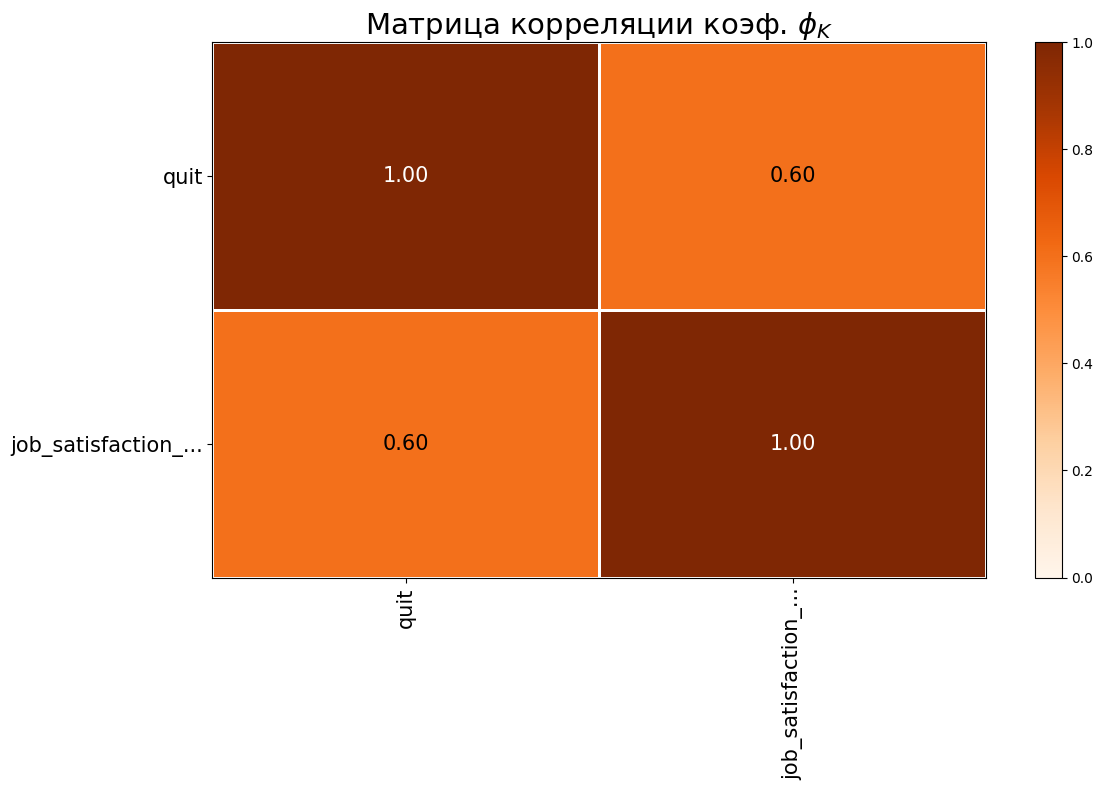

In [183]:
from phik import phik_matrix
# Преобразование 'quit' в числовой формат
compare_features['quit'] = compare_features['quit'].replace({'yes': 1, 'no': 0})

# Определение интервалов для количественных признаков
interval_cols = compare_features.select_dtypes(include='number').columns.tolist()

# Корреляционная матрица с учетом числового столбца 'quit'
phik_matrix_result = phik_matrix(compare_features.drop('id', axis=1), interval_cols=interval_cols, bins=100)

# Визуализация корреляционной матрицы
plot_correlation_matrix(
    phik_matrix_result.values,
    x_labels=phik_matrix_result.columns,
    y_labels=phik_matrix_result.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэф. $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 8)
)

Мы видим достаточно таки заметную взаимосвязь данных двух признаков. Поэтому становится очевидно, что удовлетворённость сотрудника работой в компании влияет на то, уволится ли сотрудник. Поэтому перед обучением моделей необходимо добавить признак job_satisfaction_rate к входным признакам второй задачи.

По итогу 3 шага 2ой задачи можно сделать небольшой вывод:

Так как входные признаки тестовой выборки (X_test_2) идентичны предыдущей задаче, мы провели исследовательский анализ данных для тренировочной выборки (train_2) и целевого признака тестовой выборки (y_test_2), рассмотрев все их признаки.

Касаясь количественных признаков:
В датафрейме train_2 включены такие признаки, как 'employment_years', 'supervisor_evaluation', 'salary'. В датафрейме y_test_2 этих признаков нет.

Относительно категориальных признаков:
В датафрейме train_2 встречаются 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit'. В датафрейме y_test_2 присутствует только 'quit'.

Мы построили графики для количественных признаков — гистограммы распределения и ящики с усами для каждого из них. Как и в предыдущей задаче, мы наблюдаем, что большинство сотрудников работают в компании от 1 до 10 лет, причем основная часть сотрудников имеет стаж менее 3 лет. Также заметно, что с увеличением стажа количество сотрудников снижается, и выбросы отсутствуют. Оценки руководителя варьируются от 1 до 5, причем наибольшее количество оценок приходится на 4. На графике распределения зарплат видно нормальное распределение со сдвигом влево, преобладают зарплаты около 30,000.

Теперь к категориальным признакам. Мы построили круговые диаграммы для каждого из них как для тренировочной выборки (train_2), так и для целевого признака тестовой выборки (y_test_2).

Признаки 'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations' в выборках практически идентичны первой задаче. Большинство сотрудников работает в отделах, связанных с продажами, и занимает должности на уровнях junior и middle. Около 30% сотрудников имеют средний уровень загрузки, и примерно 3% получили повышение в последний год. 13% имели нарушения трудового договора.

Отдельно стоит отметить признак 'quit'. Мы видим, что 28% сотрудников уволились из компании. Количество уволенных сотрудников одинаково в тренировочной и тестовой выборках.

Далее мы попытались составить "Портрет уволившегося сотрудника", исследовав, все признаки.

**"Портрет уволившегося сотрудника"** выгдялить следующим образом: Увольняющиеся сотрудники чаще всего работают в отделе sales, имеют должность junior и средний или низкий уровень загрузки работой. Они получают низкие оценки от руководителей (от 1 до 3) и чаще всего работают в компании менее трёх лет или совсем недолго. Большинство из них не имели нарушений трудового договора и не получали повышения за последний год. Средняя зарплата у уволившихся сотрудников значительно ниже, чем у оставшихся. Эта разница в зарплате может быть одним из ключевых факторов, влияющих на решение сотрудников об увольнении.

После, мы построили матрицу корреляции коэф. фи и проверили вияет ли удовлетворённость сотрудника работой в компании на его увольнение. Итак, анализ матрицы показывает, что уровень удовлетворённости сотрудников работой в компании (job_satisfaction_rate) влияет на вероятность их увольнения, потому что мы видим достаточно таки заметную корреляцию данных двух признаков. Это подтверждает необходимость включения признака job_satisfaction_rate в модель перед обучением для предсказания ухода сотрудников.

## Шаг 4. Добавление нового входного признака

На данном этапе работы добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [184]:
X_test_2['job_satisfaction_rate_pred'] = random_search.best_estimator_.predict(X_test)
display(X_test_2.head(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.849500
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667
2,467458,sales,middle,low,5,no,no,4,19200,0.683750


In [185]:
train_2['job_satisfaction_rate_pred'] = random_search.best_estimator_.predict(train_2.drop(['quit'], axis=1))
display(train_2.head(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.637143
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.828889
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667


В данном шаге, поскольку job_satisfaction_rate и quit действительно связаны, и в первой задаче получены удовлетворительные результаты метрики, мы добавили предсказанный лучшей моделью первой задачи признак job_satisfaction_rate к входным признакам второй задачи и готовы к подготовке данных для обучения моделей.

## Шаг 5. Подготовка данных

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки.

Разобьем данные на количественные и категориальные:

Три признака: 'dept' (отдел),'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — нужно кодировать с помощью OneHotEncoder.
Два признака: level (уровень должности) и workload (уровень загруженности) — нужно кодировать с помощью OrdinalEncoder.
Остальные количественные признаки нужно масштабировать.

Целевой признак — 'quit' (увольнение сотрудника из компании) категориальный, а это значит его надо тоже кодировать - методом LabelEncoder.

Удалим из данных ненужный признак id и проверим, не появились ли дубликаты после этого.

In [186]:
train_2_no_id = train_2.drop(['id'], axis=1)

In [187]:
print('Количество дубликатов:',train_2_no_id.duplicated().sum())

Количество дубликатов: 1413


Удалим дубликаты. Такие данные в обучающей выборке не добавляют полезной информации для модели, но могут неоправданно влиять на результаты.

In [188]:
train_2_no_id = train_2_no_id.drop_duplicates().reset_index(drop=True)

In [189]:
X_train_2 = train_2_no_id.drop(['quit'], axis=1)
y_train_2 = train_2_no_id['quit']
X_train_2.shape

(2587, 9)

In [190]:
test_2 = X_test_2.merge(y_test_2, on='id')

In [191]:
X_test_2_ = test_2.drop(['quit','id'], axis=1)
y_test_2_ = test_2['quit']
X_test_2_.shape

(2000, 9)

Делаем преобразование для машинного обучения, которое не может работать напрямую с категориальными данными. Преобразование категорий в числовые значения делает данные пригодными для обучения моделей.

In [192]:
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2_ = label_encoder.transform(y_test_2_)

Создадим второй пайплайн. Почти все данные остаются такие же как и в 1 задаче, только в num_columns добавится признак 'job_satisfaction_rate_pred'

In [193]:
ohe_columns_2 = ['dept', 'last_year_violations', 'last_year_promo']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

In [194]:
#OHE
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [195]:
#ORD
categories = [['junior', 'middle', 'senior'], ['low', 'medium', 'high']]

ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories=categories,
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [196]:
# Преобразователи для числовых данных
num_pipe_2 = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [197]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', num_pipe_2, num_columns_2)
    ], 
    remainder='passthrough'
)

In [198]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

Как и в 1 задаче, на этапе подготовки данных мы выполнили следующие действия:

Подготовка данных к обучению моделей:
Разделили данные на количественные и категориальные признаки. Определили, какие признаки требуют масштабирования, а какие кодирования. Целевой признак 'quit' (увольнение сотрудника из компании) закодировать с помощью метода LabelEncoder, т.к. это категориальный признак.

Разделение признаков для кодирования и масштабирования:
Три признака: 'dept' (отдел), 'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — закодировали с помощью OneHotEncoder. Два признака: 'level' (уровень должности) и 'workload' (уровень загруженности) — закодировали с помощью OrdinalEncoder. Остальные количественные признаки подвергли масштабированию.

Мы разделили данные тренировочной выборки и объединили тестовую выборку по 'id'. Затем создали пайплайн, который включает все шаги по подготовке данных (кодирование, масштабирование, обработка пропусков) с использованием инструмента ColumnTransformer для объединения операций по подготовке данных.

Таким образом, на этом этапе мы всесторонне подготовили данные, включая кодирование категориальных признаков, масштабирование количественных признаков и обработку пропусков, используя пайплайн. Теперь наши данные готовы для обучения моделей.

## Шаг 6. Обучение модели

Наш целевой признак — 'quit' имеет два варианта значений: да ('yes') или нет ('no'). Таким образом, наша задача — бинарная классификация. Для решения задачи бинарной классификации мы можем использовать модели логистической регрессии, KNN, дерево решений и случайный лес, при этом для всех моделей будем подбирать различные гиперпараметры.

In [199]:
param_grid_2 = [
    
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 20),
        'model__min_samples_split': range(2, 20),
        'model__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
    
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 20),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')], 
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-3, 3, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {   'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': range(100, 200, 300),
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split':[2, 5, 10],
        'model__min_samples_leaf':[1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]

Обучим 4 модели. Для оценки качества моделей будем использовать метрику ROC_AUC

In [200]:
random_search = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)

random_search.fit(X_train_2, y_train_2)
print('Лучшая модель и её параметры:\n\n', random_search.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'model__min_samples_split': 4, 'model__min_samples_leaf': 15, 'model__max_depth': 7, 'model': DecisionTreeClassifier(random_state=42)}
Метрика лучшей модели на тренировочной выборке: 0.902000335027528


Лучшей моделью оказалось дерево решений с максимальной глубиной 7, минимальным количеством образцов для разделения узла 4 и минимальным количеством образцов в листовом узле 15.

Метрика лучшей модели на тренировочной выборке получилась равна 0.90. Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику ROC_AUC.

In [201]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
# Проверяем работу модели на тестовой выборке
# y_test_pred_proba = random_search.predict(X_test_2_)
y_test_pred_proba = random_search.predict_proba(X_test_2_)[:,1]
# Рассчитываем прогноз на тестовых данных
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2_, y_test_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'last_year_violations',
                                                   'last_year_promo']),
                                  

Метрика ROC-AUC на тестовой выборке: 0.9187. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Наше значение выше 0.91 и это указывает на отличную производительность нашей модели.

Проанализируем также важность признаков для нашей лучшей модели, чтобы понять, есть ли признаки, которые не оказывают сильного влияния. Для этого воспользуемся модулем shap.

  0%|          | 0/30 [00:00<?, ?it/s]

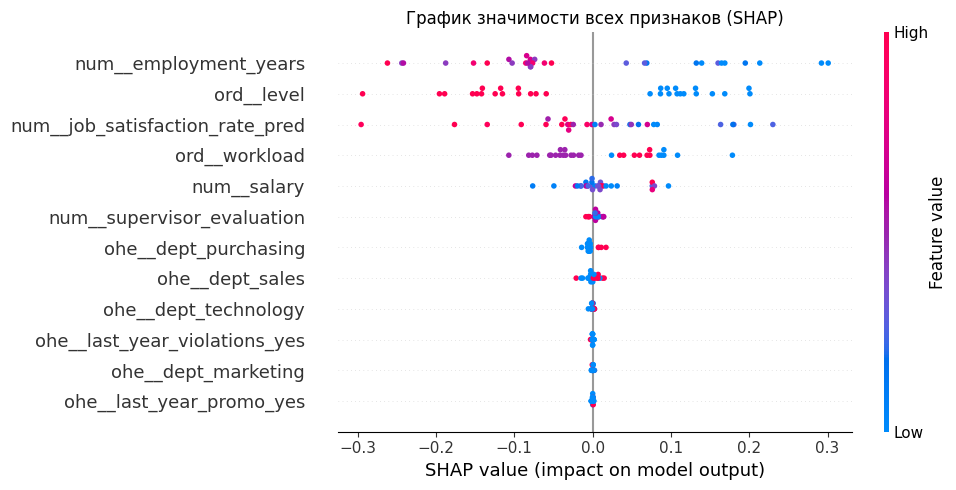

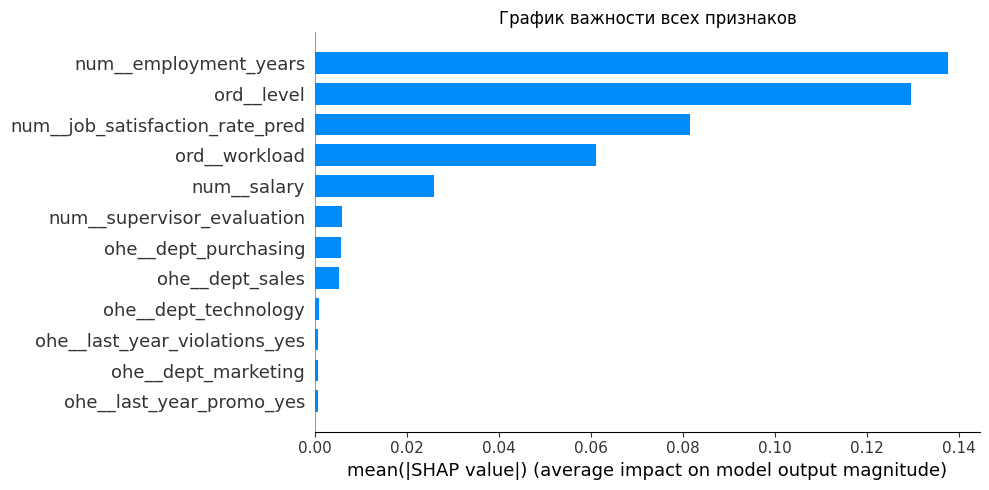

In [202]:
# Используем 30 примеров для SHAP
X_train_sample = X_train_2.sample(n=30, random_state=RANDOM_STATE)
X_test_sample = X_test_2_.sample(n=30, random_state=RANDOM_STATE)

X_train_p = pd.DataFrame(random_search.best_estimator_.steps[0][1].fit_transform(X_train_sample),
                         columns=random_search.best_estimator_.steps[0][1].get_feature_names_out())
X_test_p = pd.DataFrame(random_search.best_estimator_.steps[0][1].transform(X_test_sample),
                         columns=random_search.best_estimator_.steps[0][1].get_feature_names_out())

model = random_search.best_estimator_.steps[1][1]

# Использование KernelExplainer для генерации SHAP значений
explainer = shap.KernelExplainer(model.predict_proba, X_train_p)
shap_values = explainer.shap_values(X_test_p)

# Построение summary plot
plt.figure(figsize=(20, 8))
plt.title('График значимости всех признаков (SHAP)')
shap.summary_plot(shap_values[:, :, 1], X_test_p, plot_size=(10,5))
plt.show()

# Построение bar plot для важности признаков
plt.title('График важности всех признаков')
shap.summary_plot(shap_values[:, :, 1], X_test_p, plot_type='bar', plot_size=(10,5))
plt.show()

Как мы видим, для нашей модели наиболее важными признаками оказались признаки level (уровень) и employment_years (длительность работы), а вот признаки с повышением сотрудника (last_year_promo), нарушением трудового договора (last_year_violations) и отделом (dept) похоже мало влияют на нашу модель. Данный анализ важности признаков помогает нам понять, какие факторы наиболее существенно влияют на модель, а какие имеют меньшее значение. Это знание можно использовать для улучшения модели, например, путем фокусировки на ключевых признаках или оптимизации обработки менее важных признаков.

Итак, в данном шаге мы обучили четыре модели.
У нас целевой признак — 'quit', который принимает два значения: 'yes' и 'no', поэтому это задача бинарной классификации. Для решения задачи бинарной классификации мы рассмотрели следующие модели: логистическая регрессия, K-ближайших соседей (KNN), дерево решений и случайный лес. Для каждой модели мы провели подбор различных гиперпараметров.

Потом мы обучили четыре модели с использованием различных гиперпараметров. Для оценки качества моделей использовали метрику ROC-AUC.

На основании оценки качества моделей лучшей оказалась модель дерева решений с параметрами: (максимальная глубина: 7, минимальное количество образцов для разделения узла: 4, минимальное количество образцов в листовом узле: 15).

Метрика лучшей модели на тренировочной выборке равна 0.9020. Это значение указывает на хорошую производительность модели на тренировочных данных. Метрика ROC-AUC на тестовой выборке равна 0.9187. Критерий успеха для нашей задачи установлен как ROC-AUC ≥ 0.91. Наше значение превышает этот критерий, что свидетельствует о отличной производительности модели на тестовых данных.

Также мы провели анализ важности признаков с помощью модуля SHAP, чтобы понять влияние различных факторов на модель. Признаки 'level' (уровень) и 'employment_years' (длительность работы) оказались наиболее значимыми для модели. Признаки, такие как 'last_year_promo' (повышение сотрудника), 'last_year_violations' (нарушение трудового договора) и 'dept' (отдел), имеют меньшее влияние на модель.

Этот анализ важности признаков помогает выявить ключевые факторы, влияющие на модель, и понять, какие признаки можно оптимизировать или пересмотреть для улучшения модели. Мы можем использовать эту информацию для дальнейшего улучшения модели, например, сосредоточив внимание на наиболее значимых признаках или улучшая обработку менее важных.

## Шаг 7. Выводы

Нашей второй задачей было построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. Для этого мы обучили 4 модели и выявили какая из них справилась лучше.

На основе проведенного анализа, дерево решений с оптимизированными гиперпараметрами показало наилучшие результаты в задаче бинарной классификации, что делает его наиболее подходящей моделью для текущей второй задачи. Высокое значение метрики ROC-AUC (0.9187) свидетельствует о том, что модель успешно различает классы и делает точные предсказания.

Вероятно дерево решений справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров. К тому же дерево решений способно захватывать сложные нелинейные зависимости между признаками и целевой переменной. В данном случае, структура данных может содержать такие нелинейные взаимодействия, которые дерево решений эффективно моделирует. Дерево решений создает разбиение пространства признаков на основе наиболее информативных признаков. Это позволяет модели фокусироваться на ключевых аспектах данных и делать более точные предсказания.

# Общий вывод

Итак, в данной работе перед нами стояло 2 задачи:

1) Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2) Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Эти задачи являются важными для бизнеса, так как уровень удовлетворённости напрямую влияет на отток сотрудников, и предсказание оттока является ключевой задачей HR-аналитиков, направленной на уменьшение рисков, связанных с потерей ценных сотрудников.

1.

Мы начали с анализа исходных данных, обнаружив пропуски в колонках 'dept' и 'level'. Решили отложить обработку этих пропусков до этапа работы с пайплайном, чтобы сохранить целостность данных. Проверили данные на наличие полных и неявных дубликатов, и не обнаружили их. Нашли пустые значения в двух колонках тестовой выборки и заменили их на NaN. Также мы убедились в корректности типов данных во всех столбцах.

После мы приступили к исследовательскому анализу данных. Построили графики по количественным признакам — гистограмму частотности распределения и ящик с усами для каждого признака. Построили круговые диаграммы по каждому категориальному признаку.

Количественные признаки:

1) Длительность работы в компании (employment_years): Сотрудники работают в компании от 1 до 10 лет. В обеих выборках большинство сотрудников имеют стаж не более 3 лет. С увеличением стажа наблюдается снижение числа сотрудников. Выбросов нет, данные выглядят нормально.
2) Оценка качества работы сотрудника (supervisor_evaluation): Оценки руководителей варьируются от 1 до 5, с наибольшим числом оценок 4. Аномалий или выбросов в данных не выявлено.
3) Ежемесячная зарплата сотрудника (salary): Зарплаты варьируются от 12,000 до 100,000, при этом большинство сотрудников получает около 34,000. Выбросов в данных не наблюдается.
4) Уровень удовлетворённости сотрудника работой в компании (job_satisfaction_rate): Значения варьируются от 0.03 до 1.0. Распределение близко к нормальному с небольшим сдвигом вправо, аномальных значений нет.

Категориальные признаки:

1) Отдел, в котором работает сотрудник (dept): Наибольшее количество сотрудников работает в отделе продаж, наименьшее – в HR.
2) Уровень занимаемой должности (level): Большинство сотрудников занимают должности Junior и Middle, меньшая часть — Senior.
3) Уровень загруженности сотрудника (workload): Большинство сотрудников имеют средний уровень загруженности, около 30% работают с низкой загрузкой.
4) Повышение за последний год (last_year_promo): Только 3% сотрудников получили повышение за последний год.
5) Нарушения трудового договора за последний год (last_year_violations): Нарушения были у 13-14% сотрудников.

Кроме того, мы призвели корреляционный анализ. Анализ корреляционной матрицы показал, что большинство коэффициентов корреляции находятся в допустимых пределах, что указывает на отсутствие значительной линейной зависимости между признаками. Лишь в редких случаях значения корреляции приближаются к 0.7.

Потом мы выполнили всестороннюю подготовку данных, после которой наши данные стали готовы для обучения моделей. Для начала разделили данные на количественные и категориальные признаки. Определили, какие признаки требуют масштабирования, а какие — кодирования.
Три признака: 'dept' (отдел), 'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — закодировали с помощью OneHotEncoder.
Два признака: 'level' (уровень должности) и 'workload' (уровень загруженности) — закодировали с помощью OrdinalEncoder.
Остальные количественные признаки подвергли масштабированию.

Определили, что целевым признаком является 'job_satisfaction_rate' (удовлетворённость сотрудника работой в компании). Разделили данные тренировочной выборки и объединили тестовую выборку по 'id'. Создали пайплайн, который включает все шаги по подготовке данных: кодирование, масштабирование, обработка пропусков. Применили инструмент ColumnTransformer, который объединяет операции по подготовке данных.

После подготовки данных мы обучили две модели: линейную регрессию (LinearRegression) и дерево решений (DecisionTreeRegressor), подобрав для них оптимальные гиперпараметры.

DecisionTreeRegressor и LinearRegression были выбраны для исследования, так как они представляют различные подходы к моделированию данных. Дерево решений способно выявлять нелинейные зависимости, которые могут быть упущены линейной регрессией, и наоборот. Это позволило получить более полное понимание данных и выбрать наилучшую модель для предсказания уровня удовлетворенности сотрудников.

Лучшей моделью оказалось дерево решений (DecisionTreeRegressor) с максимальной глубиной 14, минимальным количеством образцов для разбиения узла 2 и минимальным количеством образцов в листовом узле 3.

Для оценки качества моделей мы использовали метрику SMAPE (симметричное среднее абсолютное процентное отклонение). Проверка на тестовой выборке показала, что метрика SMAPE составила 13.63, что лучше, чем на тренировочной выборке. Это свидетельствует о высоком качестве работы модели и её способности показывать стабильные и точные результаты при прогнозировании на новых данных. Наша модель демонстрирует хорошие результаты, делая её эффективным инструментом для прогнозирования уровня удовлетворенности сотрудников.

Вероятно, дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров. Дерево решений автоматически выявляет и учитывает нелинейные зависимости между признаками, что может быть упущено линейной регрессией. Глубина дерева и другие гиперпараметры были оптимизированы так, чтобы модель могла точно адаптироваться к специфике наших данных, что привело к более точным прогнозам.

Исходя из сравнения производительности моделей, дерево решений оказалось предпочтительным выбором для нашей задачи предсказания уровня удовлетворённости сотрудников. Его способность улавливать сложные взаимосвязи в данных позволила достичь более точных результатов на тестовой выборке по сравнению с линейной регрессией. Это подчеркивает важность выбора модели, которая наилучшим образом соответствует особенностям и требованиям конкретной задачи в области прогнозирования.

Наши действия на этом этапе работы позволили не только эффективно подготовить данные для моделирования, но и успешно построить модель, способную предсказывать уровень удовлетворённости сотрудников. Высокий уровень точности модели на тестовой выборке свидетельствует о её потенциале в реальных условиях бизнеса.

Таким образом, наше исследование и модель машинного обучения стали не только инструментом для предсказания удовлетворённости сотрудников, но и важным шагом в улучшении управления ресурсами и сокращении рисков оттока сотрудников для компании.

2.

Во второй части работы перед нами стоит задача построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Сначала, как и в первой задаче мы загрузили данные и провели их первичный анализ. Обнаружив пропуски в столбцах 'dept' и 'level' в тестовой выборке, мы решили отложить их обработку до этапа работы с пайплайном. Мы проверили данные на наличие полных и неявных дубликатов, но не обнаружили их. Пропуски в двух колонках тестовой выборки были заменены на NaN. Все данные оказались корректными, и никаких ошибок в новых колонках 'quit' в тренировочной и тестовой выборках не было найдено.

Далее мы провели исследовательский анализ данных, разделив их на количественные и категориальные признаки. Для количественных признаков, таких как 'employment_years', 'supervisor_evaluation', 'salary', были построены гистограммы и ящики с усами. В данных наблюдались тенденции, аналогичные предыдущей задаче. Как и в предыдущей задаче, мы наблюдаем, что большинство сотрудников работают в компании от 1 до 10 лет, причем основная часть сотрудников имеет стаж менее 3 лет. Также заметно, что с увеличением стажа количество сотрудников снижается, и выбросы отсутствуют. Оценки руководителя варьируются от 1 до 5, причем наибольшее количество оценок приходится на 4. На графике распределения зарплат видно нормальное распределение со сдвигом влево, преобладают зарплаты около 30,000.

Также мы проанализировали категориальные признаки ('dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit') с помощью круговых диаграмм, выявив общие тенденции в данных. Большинство сотрудников работает в отделах, связанных с продажами, и занимает должности на уровнях junior и middle. Около 30% сотрудников имеют средний уровень загрузки, и примерно 3% получили повышение в последний год. 13% имели нарушения трудового договора. Отдельно стоит отметить признак 'quit'. Мы заметили, что 28% сотрудников уволились из компании.
Составили "Портрет уволившегося сотрудника", и обнаружили, что такие сотрудники чаще всего работают в отделе продаж, занимают должности начального уровня, имеют средний или низкий уровень загруженности, получают низкие оценки от руководителей, работают в компании менее трёх лет и не имели нарушений трудового договора или повышений за последний год. Средняя зарплата у таких сотрудников была значительно ниже.

Такой результат можно объяснить несколькими факторами:

Сотрудники на начальных уровнях часто испытывают неуверенность в карьерных перспективах и могут быть более склонны к поиску новых возможностей, особенно если не видят быстрого карьерного роста или удовлетворения от текущей работы.
Сотрудники с низкой загруженностью могут чувствовать себя недооценёнными или неиспользуемыми в компании, что также может способствовать их желанию изменить место работы.
Низкие оценки от руководителя могут свидетельствовать о несоответствии ожиданий сотрудника и реальной ситуации в компании, что может вызывать недовольство и повышать вероятность увольнения.
Сотрудники, которые недавно присоединились к компании, могут ещё находиться в процессе адаптации и поиска оптимальной среды работы. Если они не находят подходящей атмосферы или возможностей для роста, они могут быстрее решиться на уход.
Факт отсутствия повышения среди уволившихся сотрудников может свидетельствовать о неудовлетворённости карьерными перспективами или отсутствием стимулов для долгосрочного пребывания в компании. Это может быть одним из факторов, способствующих принятию решения об уходе.

К тому же, проведя корреляционный анализ, мы выяснили, что уровень удовлетворенности сотрудников работой (job_satisfaction_rate) заметно коррелирует с их увольнением. Это подтвердило необходимость включения данного признака в модель. Поскольку job_satisfaction_rate и quit действительно связаны, и в первой задаче получены удовлетворительные результаты метрики, мы добавили предсказанный лучшей моделью первой задачи признак job_satisfaction_rate к входным признакам второй задачи и готовы к подготовке данных для обучения моделей.

Потом мы выполнили всестороннюю подготовку данных, включая кодирование категориальных признаков, масштабирование количественных признаков и обработку пропусков, используя пайплайн. Три признака: 'dept' (отдел), 'last_year_violations' (нарушения трудового договора) и 'last_year_promo' (повышение за последний год) — закодировали с помощью OneHotEncoder. Два признака: 'level' (уровень должности) и 'workload' (уровень загруженности) — закодировали с помощью OrdinalEncoder. Остальные количественные признаки подвергли масштабированию. В результате данные стали готовыми для дальнейшего обучения моделей.

После всей подготовки, мы обучили четыре модели: логистическую регрессию, K-ближайших соседей (KNN), дерево решений и случайный лес. Для каждой модели провели подбор гиперпараметров и оценили их качество с помощью метрики ROC-AUC.

Лучшей моделью оказалось дерево решений с параметрами: максимальная глубина — 7, минимальное количество образцов для разделения узла — 4, минимальное количество образцов в листовом узле — 15. Метрика ROC-AUC на тестовой выборке составила 0.9187, что превышает наш критерий успеха (ROC-AUC ≥ 0.91) и свидетельствует об отличной производительности модели.

Также, с помощью модуля SHAP мы провели анализ важности признаков. Наиболее значимыми для модели оказались 'level' (уровень) и 'employment_years' (длительность работы). Признаки 'last_year_promo' (повышение сотрудника), 'last_year_violations' (нарушение трудового договора) и 'dept' (отдел) имели меньшее влияние. Данный анализ важности признаков помогает нам понять, какие факторы наиболее существенно влияют на модель, а какие имеют меньшее значение. Это знание можно использовать для улучшения модели, например, путем фокусировки на ключевых признаках или оптимизации обработки менее важных признаков.

Таким образом, дерево решений продемонстрировало высокую точность и стабильность при предсказании увольнения сотрудников, что делает его предпочтительной моделью для данной задачи. Способность модели улавливать сложные взаимосвязи в данных позволила достичь лучших результатов. Вероятно дерево решений справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров. К тому же дерево решений способно захватывать сложные нелинейные зависимости между признаками и целевой переменной. В данном случае, структура данных может содержать такие нелинейные взаимодействия, которые дерево решений эффективно моделирует. Дерево решений создает разбиение пространства признаков на основе наиболее информативных признаков. Это позволяет модели фокусироваться на ключевых аспектах данных и делать более точные предсказания.



На основании исследования мы можем определить рекомендации и предложения для бизнеса:

 - Использовать результаты модели предсказания уровня удовлетворенности сотрудников для выявлении ключевых факторов, влияющих на удовлетворенность. Фокусироваться на улучшении этих аспектов.
 - Регулярно проводить опросы удовлетворенности сотрудников, чтобы выявлять проблемы на ранней стадии и принимать меры по их устранению.
 - Разработать программы поддержки и улучшения для сотрудников с низким уровнем удовлетворенности, предоставляя им ресурсы и возможности для профессионального роста и развития.
 - Внедрение программы наставничества для младших сотрудников (т.к. увольняются по большей части новые сотрудники), чтобы помочь им адаптироваться и развиваться в компании. Разработать программы, показывающие перспективы развития для младших сотрудников, чтобы уменьшить их неуверенность в карьерных перспективах.
 - Применять модель предсказания увольнений при найме новых сотрудников. Сосредоточиться на кандидатах, которые с оторые с меньшей вероятностью уволятся в ближайшие годы.
 - Использовать предсказательную модель для раннего выявления сотрудников, склонных к увольнению, и принимать допольнительные меры, такие как тренинги или улучшение условий работы.
 - Анализировать данные о загрузке и условиях труда сотрудников, чтобы определить и устранить возможные проблемы. Перераспределяйте задачи и улучшайте рабочие условия для повышения удовлетворенности.
 - Использовать данные для регулярного пересмотра заработных плат, чтобы убедиться, что они соответствуют или превосходят рыночные стандарты. Недооценка может быть одним из факторов, способствующих увольнениям.
 - Продолжать использовать модели для мониторинга уровня удовлетворенности и вероятности увольнений сотрудников. Регулярно обновляйте модели новыми данными для поддержания их актуальности и точности.
 - Оценивать эффективность принятых мер по повышению удовлетворенности и снижению текучести кадров. Корректировать стратегии на основе полученных данных и результатов анализа.

Внедрение этих рекомендаций, основанных на решенных задачах, поможет компании создать более стабильную и удовлетворенную рабочую силу, что приведет к повышению общей эффективности и успешности бизнеса. Это может помочь компании не только снизить текучесть кадров, но и создать более привлекательные условия для сотрудников, что в свою очередь повысит их продуктивность и лояльность к компании.